# Model#6
<img src="Model6.png">

## Cell OCV curve

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import special
import time
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression
from sympy import *

In [2]:
%config InlineBackend.figure_formats = {'png', 'retina'}
pd.set_option("display.max_rows", 10)

In [3]:
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

In [4]:
def DOD_norm(df, dod_s, dod_e):
    df = df - np.min(df)
    b = (dod_e - dod_s)/np.max(df)
    df = df*b
    df = df + dod_s
    return df

In [5]:
def DOD_norm2(df, x_s, x_e):
    return (df - x_s) * 100/(x_e - x_s)

In [6]:
def re_DOD_norm2(df, x_s, x_e):
    return df*(x_e - x_s)/100 +  x_s

In [7]:
def dQdV(df_x, df_y, delta):
    dQ = abs(np.roll(df_x, delta) - np.roll(df_x, -delta))
    dV = abs(np.roll(df_y, delta) - np.roll(df_y, -delta))
    dQ = np.where(dQ <=0, np.nan, dQ)
    df_dQdV = dV/dQ
    df_dQdV[:delta] = np.nan
    df_dQdV[-delta:] = np.nan
    return df_dQdV

In [8]:
def smooth(df, delta):
    df_tmp = np.zeros((2*delta, len(df)))
    for i in range(delta):
        df_tmp[(i-1),:] = np.roll(df, i)
        df_tmp[(i-1+delta),:] = np.roll(df, -i)
    df_tmp2 = np.median(df_tmp, axis=0)
    df_tmp2[:delta] = np.nan
    df_tmp2[-delta:] = np.nan
    
    return df_tmp2

# OCV curve

In [9]:
df_LCO_OCV = pd.read_csv('LCO_OCV1.csv')
df_LCO_OCV.columns = ['x', 'Potential(V)']
df_LCO_OCV = df_LCO_OCV.sort_values(by=['x'], ascending=False)
df_LCO_OCV = df_LCO_OCV.reset_index(drop=True)
df_LCO_OCV['x'] = 1-df_LCO_OCV['x']

df_LCO_OCV['x'] = smooth(df_LCO_OCV['x'],20)
df_LCO_OCV['Potential(V)'] = smooth(df_LCO_OCV['Potential(V)'], 20)
df_LCO_OCV = df_LCO_OCV.dropna()
df_LCO_OCV = df_LCO_OCV.sort_values(by=['x'], ascending=True)

In [10]:
df_LiC6_OCV = pd.read_csv('LiC6_OCV1.csv')
df_LiC6_OCV.columns = ['x', 'Potential(V)']
df_LiC6_OCV = df_LiC6_OCV.sort_values(by=['x'], ascending=False)
df_LiC6_OCV = df_LiC6_OCV.reset_index(drop=True)
df_LiC6_OCV['x'] = 1-df_LiC6_OCV['x']
df_LiC6_OCV['x'] = smooth(df_LiC6_OCV['x'],10)
df_LiC6_OCV['Potential(V)'] = smooth(df_LiC6_OCV['Potential(V)'], 10)
df_LiC6_OCV = df_LiC6_OCV.dropna()
df_LiC6_OCV = df_LiC6_OCV.sort_values(by=['x'], ascending=True)

In [11]:
x_p_s = 0.2
x_p_e = 0.99
x_n_s = 0.17
x_n_e = 0.94

df_LCO_OCV['DOD']  = DOD_norm2(df_LCO_OCV['x'], x_p_s, x_p_e)
df_LiC6_OCV['DOD']  = DOD_norm2(df_LiC6_OCV['x'], x_n_s, x_n_e)

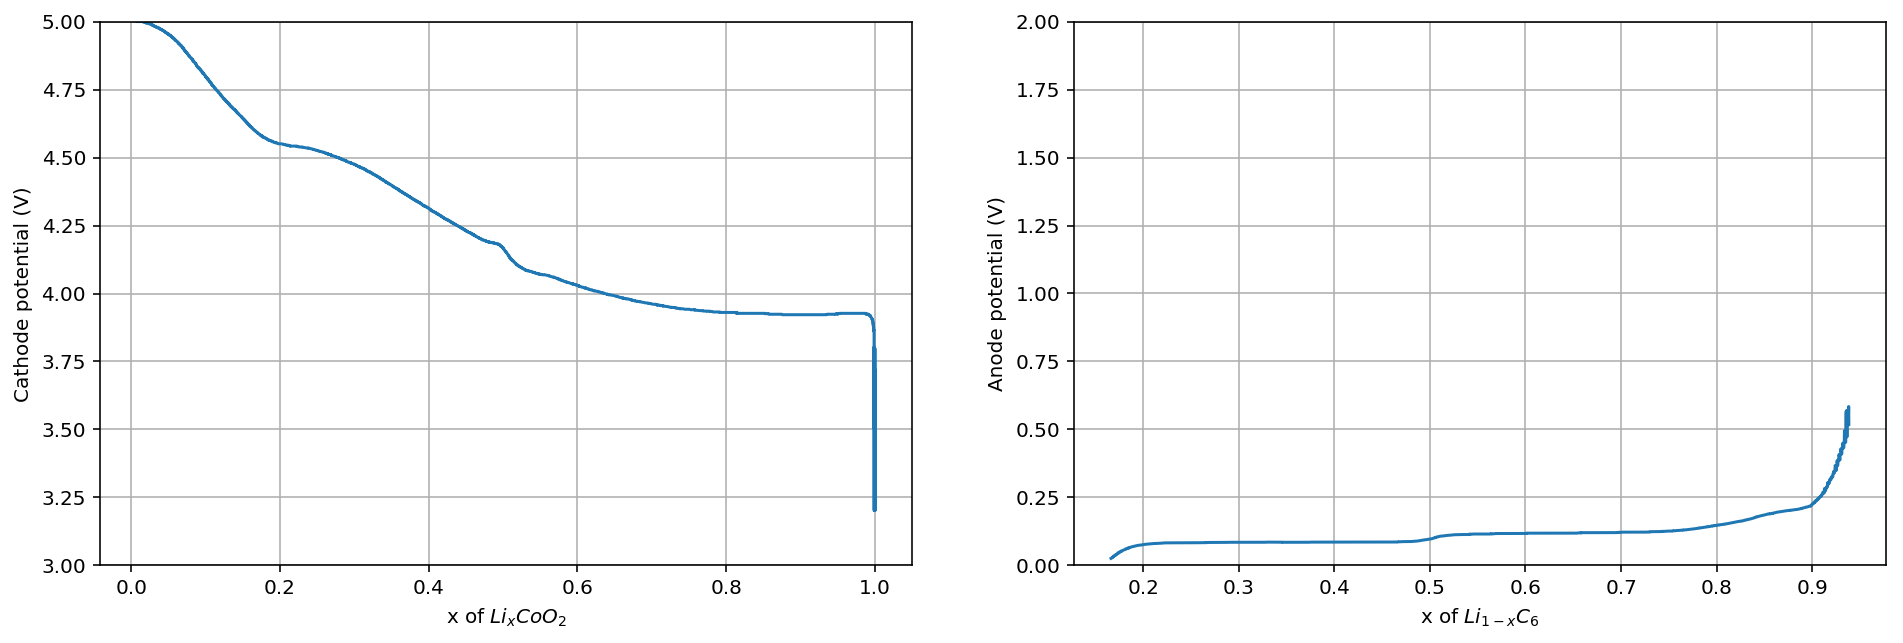

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

ax1.plot(df_LCO_OCV['x'], df_LCO_OCV['Potential(V)'])
ax1.set_ylim([3, 5])
ax1.set_ylabel('Cathode potential (V)')
ax1.set_xlabel('x of $Li_{x}CoO_2$')
ax1.grid()

ax2.plot(df_LiC6_OCV['x'], df_LiC6_OCV['Potential(V)'])
ax2.set_ylim([0, 2])
ax2.set_ylabel('Anode potential (V)')
ax2.set_xlabel('x of $Li_{1-x}C_6$')
ax2.grid()
plt.show()

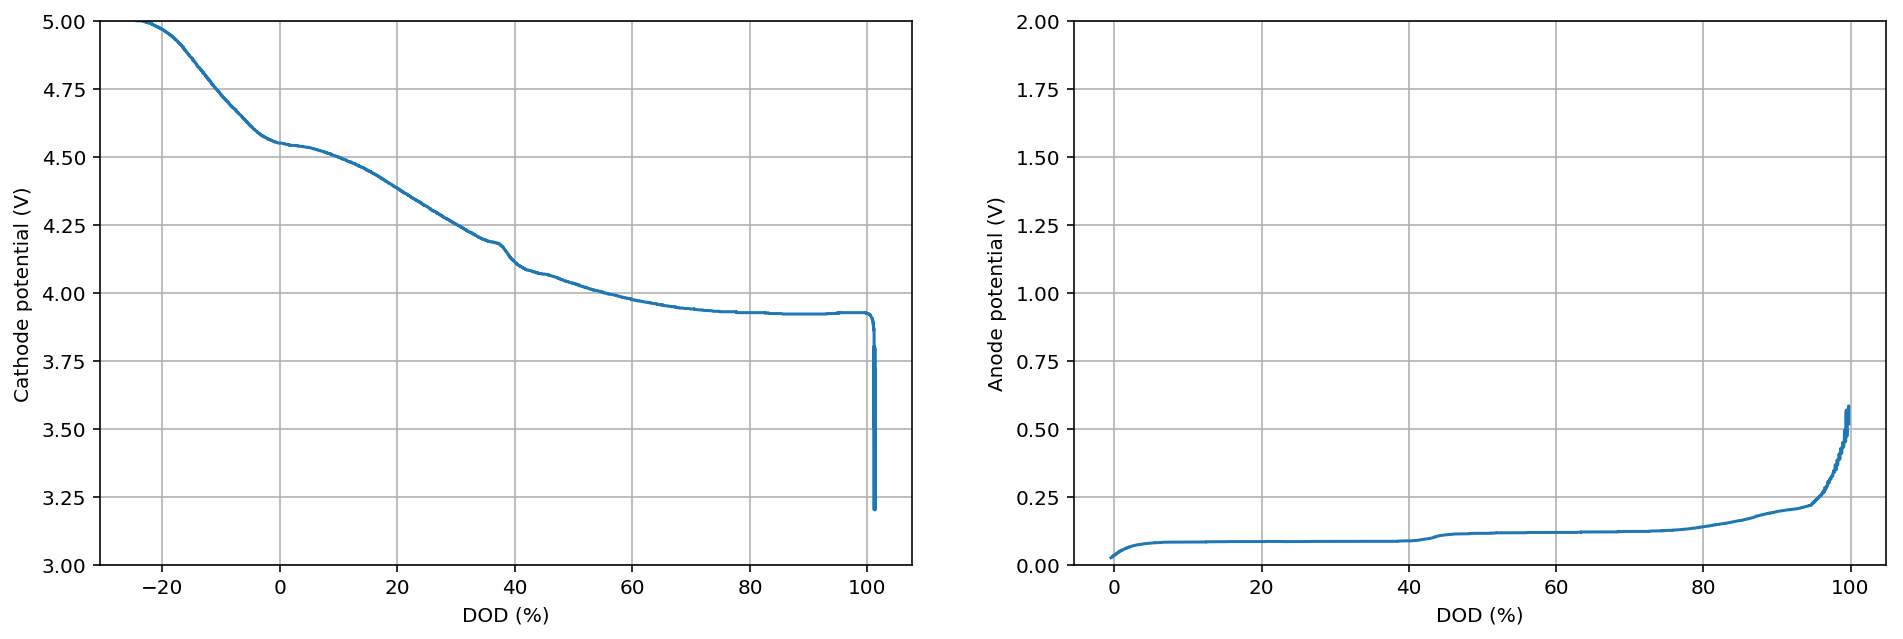

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

ax1.plot(df_LCO_OCV['DOD'], df_LCO_OCV['Potential(V)'])
ax1.set_ylim([3, 5])
ax1.set_ylabel('Cathode potential (V)')
ax1.set_xlabel('DOD (%)')
ax1.grid()

ax2.plot(df_LiC6_OCV['DOD'], df_LiC6_OCV['Potential(V)'])
ax2.set_ylim([0, 2])
ax2.set_ylabel('Anode potential (V)')
ax2.set_xlabel('DOD (%)')
ax2.grid()
plt.show()

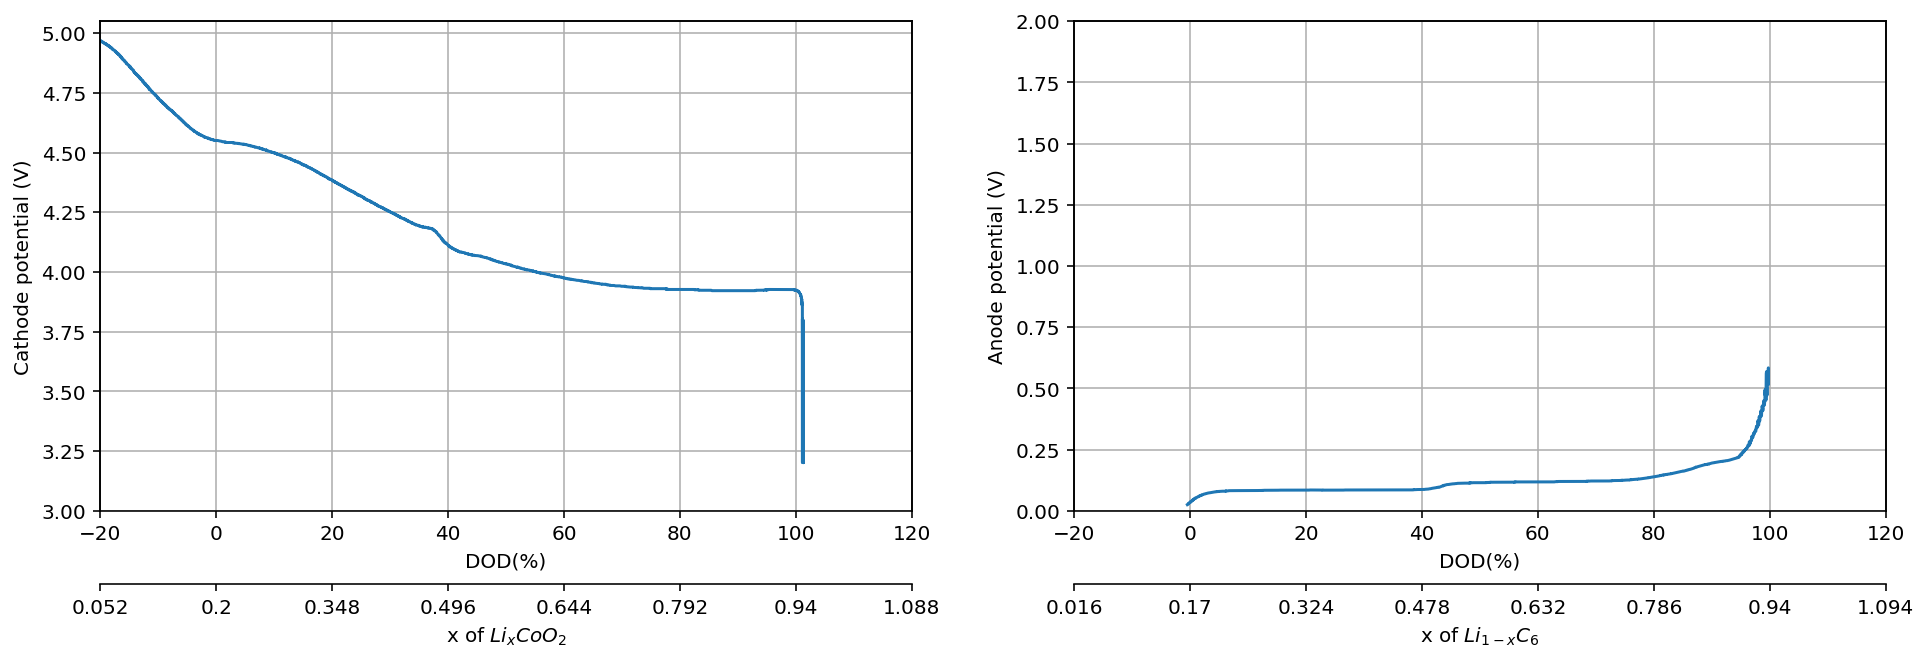

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

fig.subplots_adjust(bottom=0.2)
ax1.plot(df_LCO_OCV['DOD'], df_LCO_OCV['Potential(V)'])
ax1.set_ylim([3, 5.05])
ax1.set_xlim([-20,120])
ax1.set_ylabel('Cathode potential (V)')
ax1.set_xlabel('DOD(%)')
ax1.grid()

ax3 = ax1.twiny()
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
ax3.spines["bottom"].set_position(("axes", -0.15))

ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.spines["bottom"].set_visible(True)
ax3.set_xticks([-20,0,20,40,60,80,100,120])
ax3.set_xticklabels(re_DOD_norm2(np.array([-20,0,20,40,60,80,100,120]), x_p_s, x_n_e))
ax3.set_xlabel("x of $Li_{x}CoO_2$")


ax2.plot(df_LiC6_OCV['DOD'], df_LiC6_OCV['Potential(V)'])
ax2.set_ylim([0, 2])
ax2.set_xlim([-20,120])
ax2.set_ylabel('Anode potential (V)')
ax2.set_xlabel('DOD(%)')
ax2.grid()

ax4 = ax2.twiny()
ax4.xaxis.set_ticks_position("bottom")
ax4.xaxis.set_label_position("bottom")
ax4.spines["bottom"].set_position(("axes", -0.15))
ax4.set_frame_on(True)
ax4.patch.set_visible(False)
ax4.spines["bottom"].set_visible(True)
ax4.set_xticks([-20,0,20,40,60,80,100,120])
ax4.set_xticklabels(re_DOD_norm2(np.array([-20,0,20,40,60,80,100,120]), x_n_s, x_n_e))
ax4.set_xlabel("x of $Li_{1-x}C_6$")



plt.show()

In [15]:
df_cell = pd.DataFrame(np.arange(1001))/10
df_cell.columns = ['DOD']
df_cell = pd.merge_asof(df_cell, df_LCO_OCV, on='DOD', direction='nearest')
df_cell = pd.merge_asof(df_cell, df_LiC6_OCV, on='DOD', direction='nearest')
df_cell.columns = ['DOD', 'Cathode x (-)', 'Cathode OCV (V)', 'Anode x (-)', 'Anode OCV (V)']
df_cell['Cell OCV (V)'] = (df_cell['Cathode OCV (V)']  - df_cell['Anode OCV (V)'] )
df_cell

DOD  Cathode x (-)  Cathode OCV (V)  Anode x (-)  Anode OCV (V)  \
0       0.0        0.20032          4.55072     0.169631       0.034329   
1       0.1        0.20040          4.55072     0.170686       0.036918   
2       0.2        0.20132          4.55072     0.171753       0.039765   
3       0.3        0.20241          4.55072     0.172365       0.039610   
4       0.4        0.20341          4.54988     0.173068       0.042250   
...     ...            ...              ...          ...            ...   
996    99.6        0.98697          3.92698     0.936868       0.515807   
997    99.7        0.98797          3.92656     0.937583       0.515807   
998    99.8        0.98797          3.92656     0.938267       0.518913   
999    99.9        0.98897          3.92447     0.938267       0.518913   
1000  100.0        0.98997          3.92447     0.938267       0.518913   

      Cell OCV (V)  
0         4.516391  
1         4.513802  
2         4.510955  
3         4.511110  
4         4.507630  
...            ...  
996       3.411173  
997       3.410753  
998       3.407647  
999       3.405557  
1000      3.405557  

[1001 rows x 6 columns]

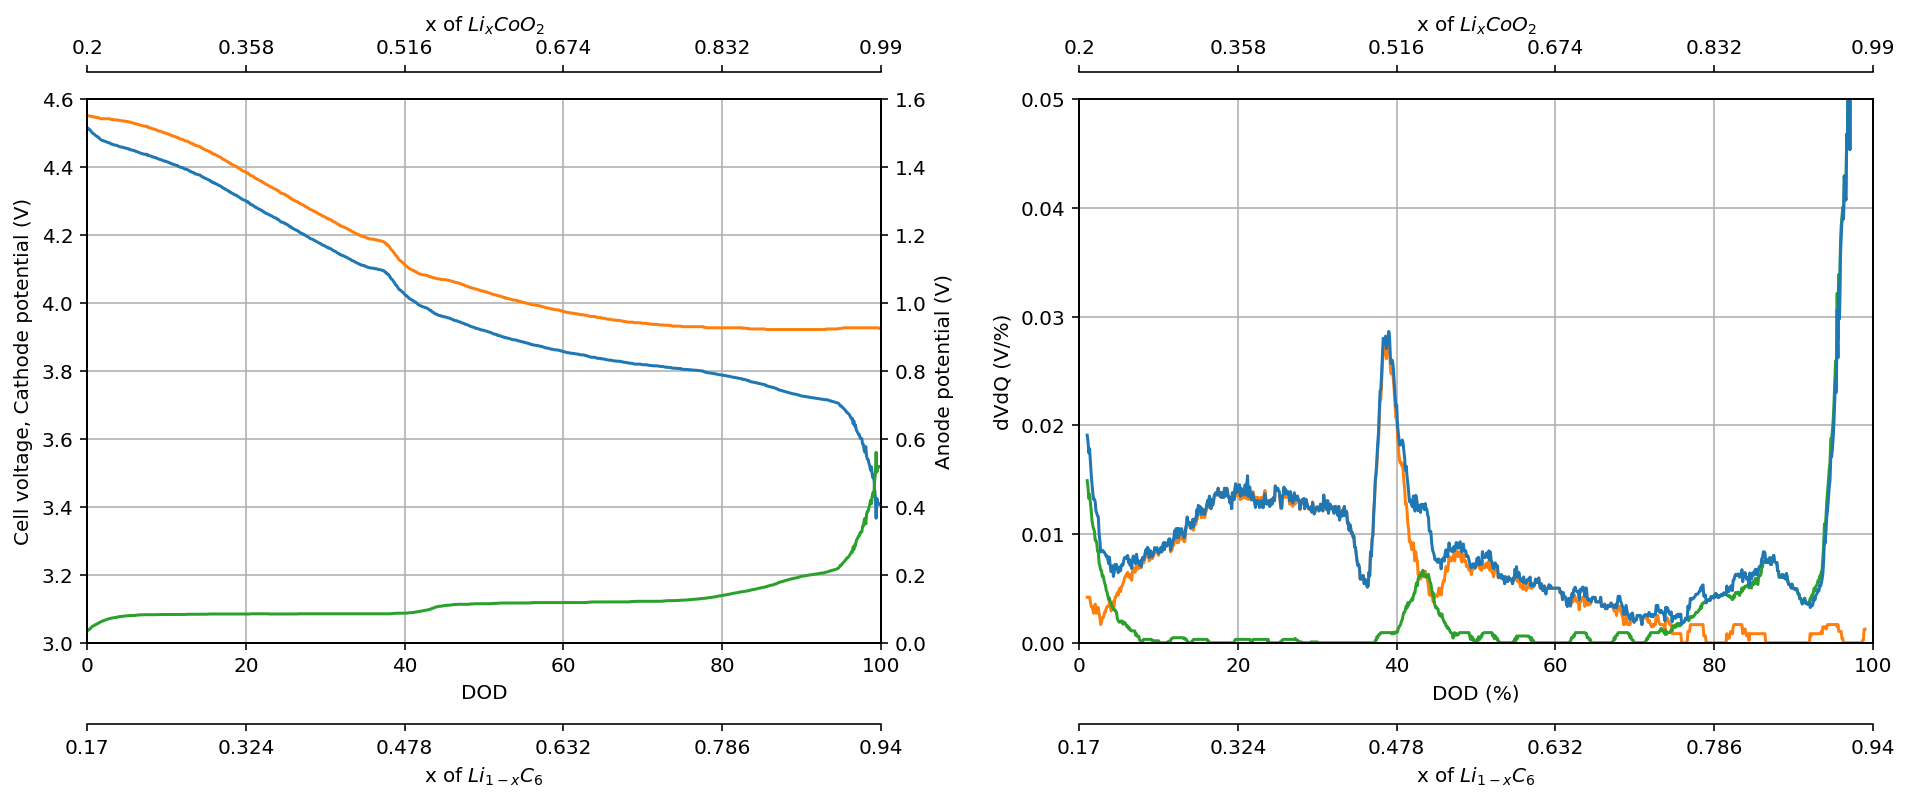

In [16]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16, 5))
plt.subplots_adjust(wspace=0.25)
ax2 = ax1.twinx()
ax1.plot(df_cell['DOD'], df_cell['Cathode OCV (V)'], color = new_colors[1])
ax1.plot(df_cell['DOD'], df_cell['Cell OCV (V)'], color = new_colors[0])
ax1.set_ylabel('Cell voltage, Cathode potential (V)')
ax2.plot(df_cell['DOD'], df_cell['Anode OCV (V)'], color = new_colors[2])
ax2.set_ylabel('Anode potential (V)')
ax1.set_xlabel('DOD')

ax1.set_ylim([3, 4.6])
ax2.set_ylim([0, 1.6])
ax1.grid()

ax1.set_xlim([0,100])
ax4 = ax1.twiny()
ax4.xaxis.set_ticks_position("bottom")
ax4.xaxis.set_label_position("bottom")
ax4.spines["bottom"].set_position(("axes", -0.15))

ax4.set_frame_on(True)
ax4.patch.set_visible(False)
ax4.spines["bottom"].set_visible(True)
ax4.set_xticks([0,20,40,60,80,100])
ax4.set_xticklabels(re_DOD_norm2(np.array([0,20,40,60,80,100]), x_n_s, x_n_e))
ax4.set_xlabel("x of $Li_{1-x}C_6$")

ax5 = ax1.twiny()
ax5.xaxis.set_ticks_position("top")
ax5.xaxis.set_label_position("top")
ax5.spines["top"].set_position(("axes", +1.05))

ax5.set_frame_on(True)
ax5.patch.set_visible(False)
ax5.spines["top"].set_visible(True)
ax5.set_xticks([0,20,40,60,80,100])
ax5.set_xticklabels(re_DOD_norm2(np.array([0,20,40,60,80,100]), x_p_s, x_p_e))
ax5.set_xlabel("x of $Li_{x}CoO_2$")

ax3.plot(df_cell['DOD'], dQdV(df_cell['DOD'], df_cell['Cathode OCV (V)'], 10), color = new_colors[1])
ax3.plot(df_cell['DOD'], dQdV(df_cell['DOD'], df_cell['Anode OCV (V)'], 10), color = new_colors[2])
ax3.plot(df_cell['DOD'], dQdV(df_cell['DOD'], df_cell['Cell OCV (V)'], 10), color = new_colors[0])

ax3.set_ylabel('dVdQ (V/%)')
ax3.set_xlabel('DOD (%)')

ax3.set_ylim([0, 0.05])
ax3.grid(which='both')

ax3.set_xlim([0,100])
ax6 = ax3.twiny()
ax6.xaxis.set_ticks_position("bottom")
ax6.xaxis.set_label_position("bottom")
ax6.spines["bottom"].set_position(("axes", -0.15))

ax6.set_frame_on(True)
ax6.patch.set_visible(False)
ax6.spines["bottom"].set_visible(True)
ax6.set_xticks([0,20,40,60,80,100])
ax6.set_xticklabels(re_DOD_norm2(np.array([0,20,40,60,80,100]), x_n_s, x_n_e))
ax6.set_xlabel("x of $Li_{1-x}C_6$")

ax7 = ax3.twiny()
ax7.xaxis.set_ticks_position("top")
ax7.xaxis.set_label_position("top")
ax7.spines["top"].set_position(("axes", +1.05))

ax7.set_frame_on(True)
ax7.patch.set_visible(False)
ax7.spines["top"].set_visible(True)
ax7.set_xticks([0,20,40,60,80,100])
ax7.set_xticklabels(re_DOD_norm2(np.array([0,20,40,60,80,100]), x_p_s, x_p_e))
ax7.set_xlabel("x of $Li_{x}CoO_2$")

plt.show()

## Diffuion in solid phase

Fick'S second law
\begin{eqnarray*}
\frac{\partial C_s(x,r,t)}{\partial t} = D_s \left( \frac{2}{r}\frac{\partial C_s(x,r,t)}{\partial r} + \frac{\partial^2 C_s(x,r,t)}{\partial r^2}\right)
\end{eqnarray*}
Boundary condition and initial condition
\begin{eqnarray*}
\frac{\partial C_s(x,r=0,t)}{\partial t} = 0\\
\frac{\partial C_s(x,r=L_s,t)}{\partial t} = j(x,t)\\
C_s(x,r,t=0)=C_{s,0}
\end{eqnarray*}

In [164]:
#Temperature
T = 298#[K]
temp_0 = 23 + 273.15#[K]


#Constant
R = 8.3144598 #[J/(mol K)]
F = 96485.33289 #[C/mol]
z = 1
alpha=0.5

k_o_p = 2.344E-11#7.13E-8
k_o_n = 5.0307E-11#1.47E-7
C_e_0 = 1000#[mol/m3]
C_s_max_p = 2.39E4 #[mol/m3]
C_s_max_n = 1.61E4 #[mol/m3]
C_s_p_0 = C_s_max_p*df_cell['Cathode x (-)'][0]
C_s_n_0 = C_s_max_n*(1 - df_cell['Anode x (-)'][0])

epsilon_e = 0.724
brugg_e = 4



#Area Dimension
S_Al = 100E-6*150E-6 #[m2]
S_Cu = 100E-6*200E-6 #[m2]
S_el = 150E-6*150E-6 #[m2]
S_p = 10*100E-6*100E-6  #[m2]
S_n = 10*100E-6*100E-6  #[m2]


#Cathode Dimension
L_Al = 100E-6 #[m]
L_p = 50E-6 #[m]
V_p = 3/4*np.pi*L_p**3  #[m3]

#Electrolyte Dimension
L_el = 10E-6 #[m]

#Anode Dimension
V_n = ((max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*V_p*F)/((max(df_cell['Anode x (-)']) - min(df_cell['Anode x (-)']))*C_s_max_n*F)
L_Cu = 100E-6  #[m]

L_n = (V_n*4/3/np.pi)**(1/3) #[m]


#1C Current per one particle
I_1C = (max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*V_p*F/60/60 #[A = C/sec]

#0.2C Current density
I = 0.2*I_1C

j_Al = I/S_Al  #(0.05ItA)[A/m2 = C/sec m2]
j_Cu = I/S_Cu  #(0.05ItA)[A/m2 = C/sec m2]
j_p = I/S_p    #(0.05ItA)[A/m2 = C/sec m2]
j_n = I/S_n    #(0.05ItA)[A/m2 = C/sec m2]
j_el = I/S_el  #(0.05ItA)[A/m2 = C/sec m2]

# Charge or Discharge
Condition = 'Discharge'
if Condition == 'Charge':
    j = abs(j)*(-1)

#Diffusion coefficient
D_p = 0.5E-11 #[m2/s]
D_n = 1.0E-11 #[m2/s]



def kappa_e(C_el,epsilon_e,brugg_e):
    return epsilon_e**brugg_e*(4.1253*1E-2 + 5.007*1E-4*C_el -4.7212*1E-7*C_el**2
                               + 1.5094*1E-10*C_el**3 - 1.6018*1E-14*C_el**4)


# Li ion concentration in Liquid phase (Electrolyte)
epsilon = 1
Deff = 7.5E-12*0.05 #[m2/sec]
t_plus = 0.363


#resistivity at 294.15K (20deg.C)
rho_0_Al = 2.82E-8#[ohm m]
rho_0_Cu = 1.68E-8#[ohm m]
alpha_Al = 0.0039#[/K]
alpha_Cu = 0.003862#[/K]

#electronic resistance of conductive agent per 1m
R_s_p = 100 #[ohm m] Temporary number
R_s_n = 100 #[ohm m] Temporary number



In [18]:
# Memo
# C = C/sec sec = A sec
# C*60*60 = Ah

In [19]:
# Cathode capacity per one particle
print((max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*V_p*F) # [C]
print((max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*V_p*F/3600) # [C/sec * sec /36000 = A sec /36000 =Ah ]
Full_cap = (max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*V_p*F/3600 #Ah

0.000536308881747
1.48974689374e-07


In [20]:
# Anode capacity per one particle
print((max(df_cell['Anode x (-)']) - min(df_cell['Anode x (-)']))*C_s_max_n*V_n*F) # [C]
print((max(df_cell['Anode x (-)']) - min(df_cell['Anode x (-)']))*C_s_max_n*V_n*F/3600) # [C/sec * sec /36000 = A sec /36000 =Ah ]

0.000536308881747
1.48974689374e-07


In [84]:
x = Symbol('x')
y = Symbol('y')
f1 = log(x) + log(y)
f2 = x - y -1
s = solve([f1,f2],[x,y])
print (s)

[(1/2 + sqrt(5)/2, -1/2 + sqrt(5)/2)]


In [147]:
def circuit2(U_pn1,U_pn2,U_pn3,
             Dphi_spn32, Dphi_spn21,
             Dphi_elpn32,Dphi_elpn21,
             DV_eta_pn1,DV_eta_pn2,DV_eta_pn3,
             I_1, I_2, I_3, Dphi_elpn,I):
    f1 = Dphi_spn21 + Dphi_spn32 - U_pn3 + DV_eta_pn3 - Dphi_elpn
    f2 = Dphi_spn21 - U_pn2 + DV_eta_pn2 + Dphi_elpn32- Dphi_elpn
    f3 = -U_pn1 + DV_eta_pn1 + Dphi_elpn32 + Dphi_elpn21- Dphi_elpn
    f4 = I_1 + I_2 + I_3 - I
    s = solve([f1,f2,f3,f4],[I_1,I_2,I_3,Dphi_elpn], dict=True)
    print((s))
    return float(s[0][I_1]), float(s[0][I_2]), float(s[0][I_3]), float(s[0][Dphi_elpn])

In [169]:
I_1 = Symbol('I_1')
I_2 = Symbol('I_2')
I_3 = Symbol('I_3')
Dphi_elpn = Symbol('Dphi_elpn')

I = I
S_pn = S_p
k_o_pn = k_o_p
dx = L_p/3

C_el_pn1 = C_e_0
C_el_pn2 = C_e_0
C_el_pn3 = C_e_0

C_s_max_pn1 = C_s_max_p
C_s_max_pn2 = C_s_max_p
C_s_max_pn3 = C_s_max_p

C_s_pn1_surface = C_s_p_0 
C_s_pn2_surface = C_s_p_0 
C_s_pn3_surface = C_s_p_0 

R_s_pn = R_s_p 

U_pn1 = df_cell['Cathode OCV (V)'][0]
U_pn2 = df_cell['Cathode OCV (V)'][0]
U_pn3 = df_cell['Cathode OCV (V)'][0]



#I = I_1 + I_2 + I_3

j_pn1 = (I_1)/S_pn
j_pn2 = (I_2)/S_pn
j_pn3 = (I_3)/S_pn


j_0_pn1 = z*F*k_o_pn*C_el_pn1**alpha*(C_s_max_pn1 - C_s_pn1_surface)**alpha*(C_s_pn1_surface)**alpha#[A/m2]
j_0_pn2 = z*F*k_o_pn*C_el_pn2**alpha*(C_s_max_pn2 - C_s_pn2_surface)**alpha*(C_s_pn2_surface)**alpha#[A/m2]
j_0_pn3 = z*F*k_o_pn*C_el_pn3**alpha*(C_s_max_pn3 - C_s_pn3_surface)**alpha*(C_s_pn3_surface)**alpha#[A/m2]


DV_eta_pn1 = (R*T)/(alpha*z*F)*log(j_pn1/(2*j_0_pn1) + ((j_pn1/(2*j_0_pn1))**2 + 1)**0.5)
DV_eta_pn2 = (R*T)/(alpha*z*F)*log(j_pn2/(2*j_0_pn2) + ((j_pn2/(2*j_0_pn2))**2 + 1)**0.5)
DV_eta_pn3 = (R*T)/(alpha*z*F)*log(j_pn3/(2*j_0_pn3) + ((j_pn3/(2*j_0_pn3))**2 + 1)**0.5)

Dphi_elpn32 = -(I_1 + I_2)*dx/kappa_e((C_el_pn3+C_el_pn2)/2, epsilon_e, brugg_e) + 2*R*T/F*(0.5 - t_plus)*(np.log(C_el_pn3) - np.log(C_el_pn2))
Dphi_elpn21 = -(I_1)*dx/kappa_e((C_el_pn2+C_el_pn1)/2, epsilon_e, brugg_e) + 2*R*T/F*(0.5 - t_plus)*(np.log(C_el_pn3) - np.log(C_el_pn2))

Dphi_spn32 = R_s_pn * dx * (I_2 + I_3)
Dphi_spn21 = R_s_pn * dx * (I_2)

#if Condition == 'Discharge':
#    Dphi_elpn31 = Dphi_spn32 + Dphi_spn21 - U_pn3 + DV_eta_pn3
#    Dphi_elpn31 = Dphi_spn32 - U_pn2 + DV_eta_pn2 + Dphi_elpn21
#    Dphi_elpn31 = -U_pn1 + DV_eta_pn1 + Dphi_elpn32 + Dphi_elpn21
    
    
#f1 = Dphi_spn32 + Dphi_spn21 + U_pn3 - DV_eta_pn3 - Dphi_elpn31
#f2 = Dphi_spn32 + U_pn2 - DV_eta_pn2 + Dphi_elpn32 - Dphi_elpn31
#f3 = U_pn1 - DV_eta_pn1 + Dphi_elpn32 + Dphi_elpn21 - Dphi_elpn31
#f4 = I_1 + I_2 + I_3 - I
    
#s = solve([f1,f2,f3,f4],[I_1,I_2,I_3,Dphi_elpn31])
    

In [171]:
#eta をlogにするとうごかない

t1=time.time()
#I_1 = Symbol('I_1')
#I_2 = Symbol('I_2')
#I_3 = Symbol('I_3')
#Dphi_elpn = Symbol('Dphi_elpn')
(circuit2(U_pn1=U_pn1*1000,U_pn2=U_pn2*1000,U_pn3=U_pn3*1000,
          Dphi_spn21=Dphi_spn21,Dphi_spn32=Dphi_spn32,
          Dphi_elpn21=Dphi_elpn21, Dphi_elpn32=Dphi_elpn32,
          DV_eta_pn1=(10*I_1),DV_eta_pn2=(10*I_2),DV_eta_pn3=(10*I_3),
          I_1=I_1, I_2=I_2, I_3=I_3, Dphi_elpn=Dphi_elpn,I=I*1e9))
print(f"{int(time.time()-t1)}sec")

[{I_1: 9.93424530337229, I_2: 9.93229561766119, I_3: 9.92839695377592, Dphi_elpn: -4451.38637548192}]
0sec


In [ ]:
#f1 = Dphi_spn32 + Dphi_spn21 + U_pn3 - DV_eta_pn3 - Dphi_elpn31
#f2 = Dphi_spn32 + U_pn2 - DV_eta_pn2 + Dphi_elpn32 - Dphi_elpn31
#f3 = U_pn1 - DV_eta_pn1 + Dphi_elpn32 + Dphi_elpn21 - Dphi_elpn31
#f4 = I_1 + I_2 + I_3 - I

In [27]:
U_pn3

4.5507200000000001

In [83]:
I_1 = Symbol('I_1')
I_2 = Symbol('I_2')
I_3 = Symbol('I_3')
Dphi_elpn = Symbol('Dphi_elpn')

I = I
S_pn = S_p
k_o_pn = k_o_p
dx = L_p/3

C_el_pn1 = C_e_0
C_el_pn2 = C_e_0
C_el_pn3 = C_e_0

C_s_max_pn1 = C_s_max_p
C_s_max_pn2 = C_s_max_p
C_s_max_pn3 = C_s_max_p

C_s_pn1_surface = C_s_p_0 
C_s_pn2_surface = C_s_p_0 
C_s_pn3_surface = C_s_p_0 

R_s_pn = R_s_p 

U_pn1 = df_cell['Cathode OCV (V)'][0]
U_pn2 = df_cell['Cathode OCV (V)'][0]
U_pn3 = df_cell['Cathode OCV (V)'][0]



#I = I_1 + I_2 + I_3

j_pn1 = (I_1)
j_pn2 = (I_2)
j_pn3 = (I_3)


DV_eta_pn1 = log(2*j_pn1)
DV_eta_pn2 = log(2*j_pn2)
DV_eta_pn3 = log(2*j_pn3)

Dphi_elpn32 = -(I_1 + I_2)
Dphi_elpn21 = -(I_1)

Dphi_spn32 = (I_2 + I_3)
Dphi_spn21 = (I_2)

if Condition == 'Discharge':
    Dphi_elpn31 = Dphi_spn32 + Dphi_spn21 + U_pn3 - DV_eta_pn3
    Dphi_elpn31 = Dphi_spn32 + U_pn2 - DV_eta_pn2 + Dphi_elpn32
    Dphi_elpn31 = U_pn1 - DV_eta_pn1 + Dphi_elpn32 + Dphi_elpn21
    
    
f1 = Dphi_spn32 + Dphi_spn21 - DV_eta_pn3 - Dphi_elpn31
f2 = Dphi_spn32  - DV_eta_pn2 + Dphi_elpn32 - Dphi_elpn31
f3 = - DV_eta_pn1 + Dphi_elpn32 + Dphi_elpn21 - Dphi_elpn31
f4 = I_1 + I_2 + I_3 - I
    
s = solve([f1,f2,f3,f4],[I_1,I_2,I_3,Dphi_elpn31])
    

In [85]:
I_1 = Symbol('I_1')
I_2 = Symbol('I_2')
I_3 = Symbol('I_3')
Dphi = Symbol('Dphi')
U = 

I_1

In [70]:
(np.log(C_el_pn3) - np.log(C_el_pn2))

0.0

In [262]:
def diffusion_in_solid_initial(L, V, C_s_0, n=10, t_total=60*60*5, dt=0.05):
    dr = L/n
    # Make an array with positions of middle of each partition
    r = np.linspace(dr/2, L - dr/2,n)
    # Initialize rod to initial temperature distribution.
    C = np.ones(len(r))*C_s_0#*4*np.pi*r**2    #[mol/m3]
    dCdt = np.empty(n)
    
    t = np.arange(0,t_total,dt)
    time_rlt = np.zeros((len(t)+1))
    r_rlt = np.zeros((len(t)+1,len(r)))
    C_rlt = np.zeros((len(t)+1,len(C)))
 
    r_rlt[0] = r
    C_rlt[0] = C
    
    return dr, r, C, dCdt, time_rlt, r_rlt, C_rlt

In [272]:
def diffusion_in_solid_update(L, S, D, j, time_rlt, C_rlt, dCdt, time_before, n=10, t_total=60*60*5, dt=0.05):
    
    #L: Radius of particle
    #V: Volume of particle
    #S: Surface area of particle
    #D: Diffusion coefficient of particle
    #C_s_0: Li concentration at t=0[sec]
    #j: Current density at particle surface
    #n: Number of partitions of rod.
    #t_total: Total charge/discharge time
    #dt: delta time
    #time_before: time one step before [sec] 
    
    dr = L/n
    t_total +=dt
    
    jj = int(time_before/dt + 1)
    
    time_now = round(time_before + dt,5)
    C = C_rlt[int(round(time_before/dt,0))]
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
#        dCdt[i] = D*(2/((i+1)*dr)*(C[i+1] - C[i])/dr) + D*((C[i+1] - C[i])/dr - (C[i] - C[i-1])/dr)/dr
        dCdt[i] = D*((C[i+1] - C[i])/dr - (C[i] - C[i-1])/dr)/dr
      
    # Taking into account boundary condition. ie. T[0-1] DNE
    #dCdt[0] = D*(2/(1*dr)*(C[1] - C[0])/dr) + D*((C[1] - C[0])/dr)/dr
    #dCdt[n-1] = D*(2/(n*dr)*(j/F/D)) + D*(j/F/D - (C[n-1] - C[n-2])/dr)/dr
    dCdt[0] = D*((C[1] - C[0])/dr)/dr
    dCdt[n-1] = D*(j*S/F/D - (C[n-1] - C[n-2])/dr)/dr
    
    C = C + dCdt * dt
    #print(C)

    time_rlt[jj] = time_now 
    C_rlt[jj] = C #concentration per dx
    
    return time_rlt, C_rlt, time_now 
    

In [281]:
t_total=60*60*5
dt=0.05
dr_p1, r_p1, C_p1, dCdt_p1, time_rlt_p1, r_rlt_p1, C_rlt_p1 = diffusion_in_solid_initial(
    L=L_p, V=V_p, C_s_0=C_s_p_0, n=10, t_total=t_total, dt=dt)
print(dr_p1)
print(r_p1)
print(dCdt_p1)
print(time_rlt_p1)
print(r_rlt_p1)
print(C_rlt_p1)

5e-06
[  2.50000000e-06   7.50000000e-06   1.25000000e-05   1.75000000e-05
   2.25000000e-05   2.75000000e-05   3.25000000e-05   3.75000000e-05
   4.25000000e-05   4.75000000e-05]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 0.  0.  0. ...,  0.  0.  0.]
[[  2.50000000e-06   7.50000000e-06   1.25000000e-05 ...,   3.75000000e-05
    4.25000000e-05   4.75000000e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
[[ 4787.648  4787.648  4787.648 ...,  4787.648  4787.648  4787.648]

In [290]:
time_rlt_p1, C_rlt_p1, time_now_p1 = diffusion_in_solid_update(
    L=L_p, S=S_p, D=D_p, j=j_p, time_rlt=time_rlt_p1, C_rlt=C_rlt_p1,
    dCdt=dCdt_p1, time_before=0, n=10, t_total=60*60*5, dt=0.05)

In [291]:
time_now_p1
time_rlt_p1

array([ 0.  ,  0.05,  0.1 , ...,  0.  ,  0.  ,  0.  ])

In [292]:
time_rlt_p1, C_rlt_p1, time_now_p1 = diffusion_in_solid_update(
    L=L_p, S=S_p, D=D_p, j=j_p, time_rlt=time_rlt_p1, C_rlt=C_rlt_p1,
    dCdt=dCdt_p1, time_before=time_now_p1, n=10, t_total=60*60*5, dt=0.05)

In [289]:
C_rlt

array([[  4.78764800e+03,   4.78764800e+03,   4.78764800e+03, ...,
          4.78764800e+03,   4.78764800e+03,   4.78764800e+03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   3.08802768e-09],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [261]:
time_now_p1=0.05
for kk in range(15):
    time_rlt_p1, C_rlt_p1, time_now_p1 = diffusion_in_solid_update(L=L_p, S=S_p, D=D_p, j=j_p, time_rlt=time_rlt_p1, C_rlt=C_rlt_p1, dCdt=dCdt_p1, time_before=time_now_p1, n=10, t_total=60*60*5, dt=0.05)

time_before
0.05
0.1
[ 4787.648  4787.648  4787.648  4787.648  4787.648  4787.648  4787.648
  4787.648  4787.648  4787.648]
1
time_before
0.1
0.15
[ 4787.648       4787.648       4787.648       4787.648       4787.648
  4787.648       4787.648       4787.648       4787.648       4787.64800001]
2
time_before
0.15
0.2
[ 4787.648       4787.648       4787.648       4787.648       4787.648
  4787.648       4787.648       4787.648       4787.648       4787.64800001]
3
time_before
0.2
0.25
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
4
time_before
0.25
0.3
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   3.08802768e-09]
5
time_before
0.3
0.35
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   3.08802768e-11   6.14517508e-09]
6
time_before
0.35
0.4
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
7
time_bef

Fick'S second law
\begin{eqnarray*}
\frac{\partial C_s(x,r,t)}{\partial t} = D_s \left( \frac{2}{r}\frac{\partial C_s(x,r,t)}{\partial r} + \frac{\partial^2 C_s(x,r,t)}{\partial r^2}\right)
\end{eqnarray*}
Boundary condition and initial condition
\begin{eqnarray*}
\frac{\partial C_s(x,r=0,t)}{\partial t} = 0\\
\frac{\partial C_s(x,r=L_s,t)}{\partial t} = j(x,t)\\
C_s(x,r,t=0)=C_{s,0}
\end{eqnarray*}

Fick'S second law
\begin{eqnarray*}
\frac{\partial C_s(x,t)}{\partial t} = D_s\frac{\partial^2 C_s(x,t)}{\partial x^2}
\end{eqnarray*}
Boundary condition and initial condition
\begin{eqnarray*}
\frac{\partial C_s(x=0,t)}{\partial t} = 0\\
\frac{\partial C_s(x=R_s,t)}{\partial t} = j(t)\\
C_s(x,t=0)=C_{s,0}
\end{eqnarray*}

In [203]:
C_rlt_p1[8]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

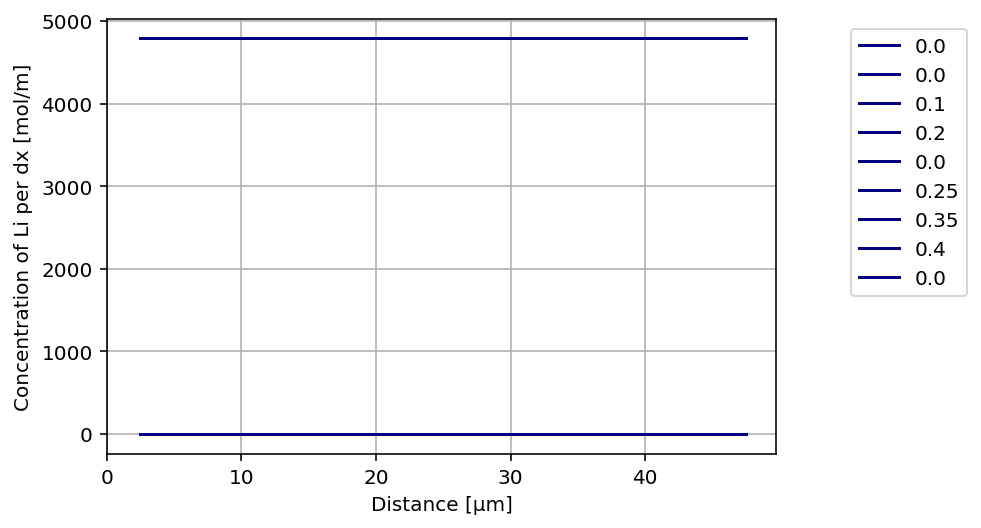

In [254]:
tt=(t_total-dt)/10000#[sec] delta time for plot
time_rlt=time_rlt_p1
x_rlt=r_rlt_p1
C_rlt=C_rlt_p1

for ii in range(9):
    plt.plot(x_rlt[0]*1E6,C_rlt[ii], label = time_rlt[ii],color=cm.jet(ii/len(time_rlt)))


#for ii in range(len(time_rlt[time_rlt % tt == 0])):
#    plt.plot(x_rlt[time_rlt % tt == 0][ii]*1E6,C_rlt[time_rlt % tt == 0][ii], label = time_rlt[time_rlt % tt == 0][ii],color=cm.jet(ii/len(time_rlt[time_rlt % tt == 0])))
#plt.plot(([0,100]),([C_s_max_p*V_p/L_p,C_s_max_p*V_p/L_p]),'--',label='C_s_max_p',color='black')
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_xlim(left=0)
#plt.gca().set_ylim(bottom=0)#.xlim(0,100)
plt.grid()
plt.show()

In [167]:
x_rlt[time_rlt % tt == 0]

array([[  2.50000000e-06,   7.50000000e-06,   1.25000000e-05, ...,
          3.75000000e-05,   4.25000000e-05,   4.75000000e-05],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [21]:
t1 = time.time()
# Number of partitions of rod (finite elements)
n = 10
dx = L_p/n

t_total = 60*60*5 #[sec] run time
dt = 0.05 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, L_p - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_s_p_0*V_p/L_p
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt = np.zeros((len(t)+1))
x_rlt = np.zeros((len(t)+1,len(x)))
C_rlt = np.zeros((len(t)+1,len(C)))
x_rlt[0] = x
C_rlt[0] = C

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = D_p*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = D_p*((C[1] - C[0])/dx)/dx
    dCdt[n-1] = D_p*(j_p*S_p/F/D_p - (C[n-1] - C[n-2])/dx)/dx
    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt[jj] = (jj)*dt
    x_rlt[jj] = x #
    C_rlt[jj] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
4.7 sec


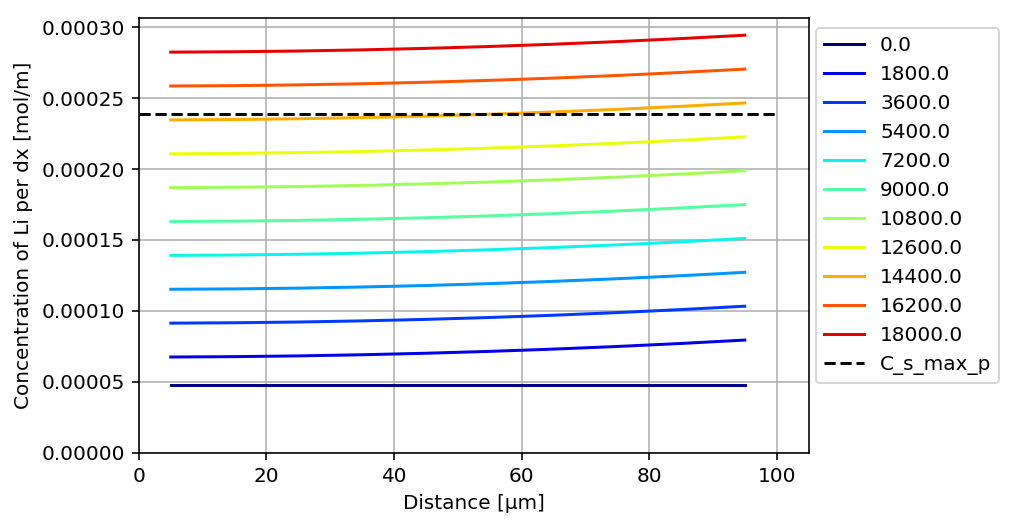

In [22]:
tt=(t_total-dt)/10#[sec] delta time for plot
for ii in range(len(time_rlt[time_rlt % tt == 0])):
    plt.plot(x_rlt[time_rlt % tt == 0][ii]*1E6,C_rlt[time_rlt % tt == 0][ii], label = time_rlt[time_rlt % tt == 0][ii],color=cm.jet(ii/len(time_rlt[time_rlt % tt == 0])))
plt.plot(([0,100]),([C_s_max_p*V_p/L_p,C_s_max_p*V_p/L_p]),'--',label='C_s_max_p',color='black')
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)#.xlim(0,100)
plt.grid()
plt.show()

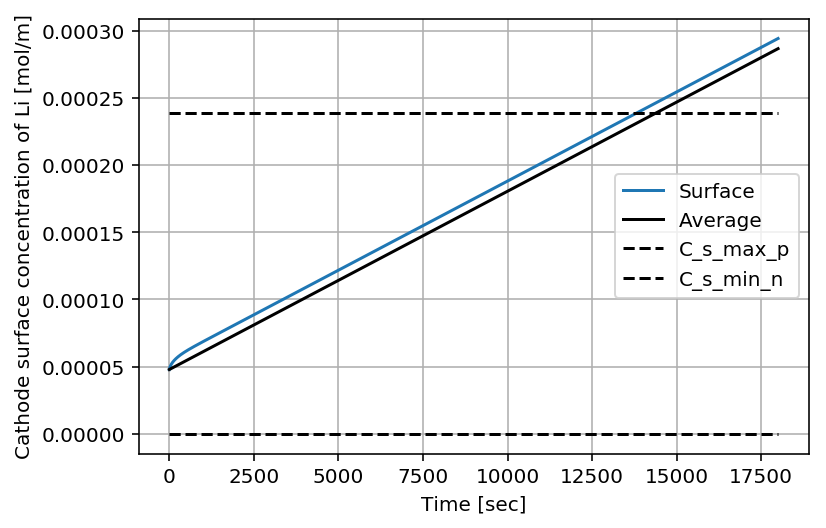

In [23]:
plt.plot(time_rlt,C_rlt[:,-1], label='Surface')
plt.plot(([0,t_total]), ([sum(C_rlt[0,:])/n, sum(C_rlt[-1,:])/n]), color = 'black', label='Average')
plt.plot(([0,t_total]),([C_s_max_p*V_p/L_p,C_s_max_p*V_p/L_p]),'--',label='C_s_max_p',color='black')
plt.plot(([0,t_total]),([0, 0]),'--',label='C_s_min_n',color='black')
plt.ylabel('Cathode surface concentration of Li [mol/m]')
plt.xlabel('Time [sec]')
plt.legend()
plt.grid()
plt.show()

In [24]:
# Convert concentration to x stoichiometric ratio of cathode.
slr_p = LinearRegression()
X_p = np.array([sum(C_rlt[0,:])/n/(V_p/L_p), 0])
y_p = np.array([min(df_cell['Cathode x (-)']), 0])
X_p = X_p.reshape(-1, 1)
y_p = y_p.reshape(-1, 1)
slr_p.fit(X_p, y_p)

/Users/takumkawahara/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
t1 = time.time()
# Number of partitions of rod (finite elements)
n = 16
dx = L_n/n

t_total = 60*60*5 #[sec] run time
dt = 0.05 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, L_n - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_s_n_0*V_n/L_n
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt_n = np.zeros(len(t)+1)
x_rlt_n = np.zeros((len(t)+1,len(x)))
C_rlt_n = np.zeros((len(t)+1,len(C)))

x_rlt_n[0] = x
C_rlt_n[0] = C

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = D_n*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = D_n*((C[1] - C[0])/dx)/dx
    dCdt[n-1] = D_n*(-j_n*S_n/F/D_n - (C[n-1] - C[n-2])/dx)/dx
    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt_n[jj] = (jj)*dt
    x_rlt_n[jj] = x #
    C_rlt_n[jj] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
7.5 sec


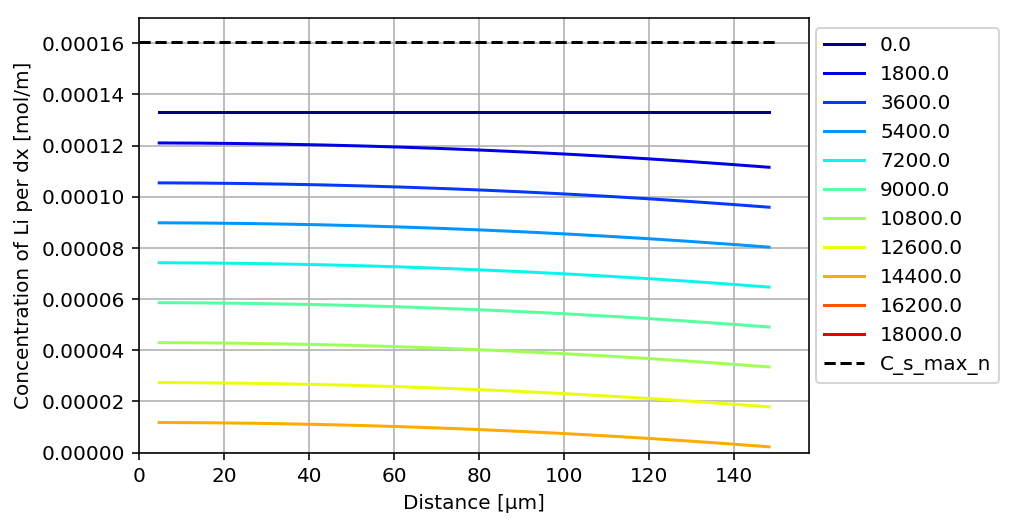

In [26]:
tt=(t_total-dt)/10#[sec] delta time for plot
for ii in range(len(time_rlt_n[time_rlt_n % tt == 0])):
    plt.plot(x_rlt_n[time_rlt_n % tt == 0][ii]*1E6,C_rlt_n[time_rlt_n % tt == 0][ii], label = time_rlt_n[time_rlt_n % tt == 0][ii],color=cm.jet(ii/len(time_rlt_n[time_rlt_n % tt == 0])))
plt.plot(([0,150]),([C_s_max_n*V_n/L_n,C_s_max_n*V_n/L_n]),'--',label='C_s_max_n',color='black')
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=0)
plt.grid()
plt.show()

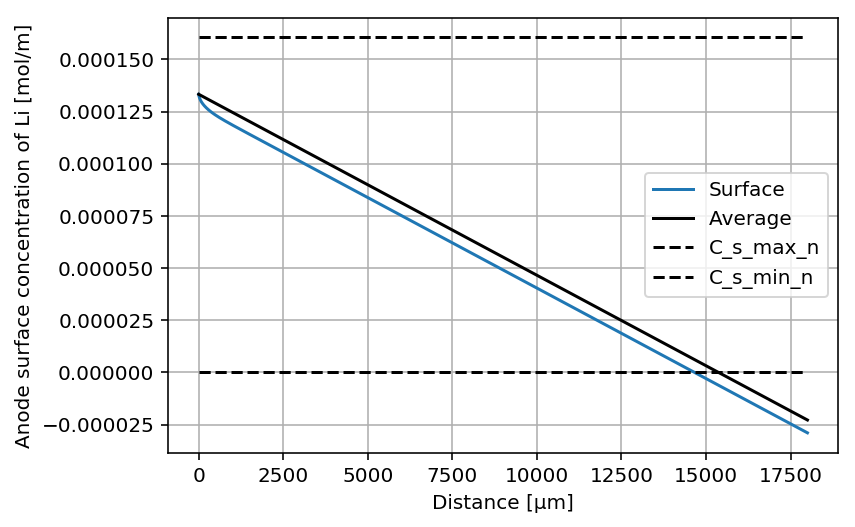

In [27]:
plt.plot(time_rlt_n,C_rlt_n[:,-1], label='Surface')
plt.plot(([0,t_total]), ([sum(C_rlt_n[0,:])/n, sum(C_rlt_n[-1,:])/n]), color = 'black', label='Average')
plt.plot(([0,t_total]),([C_s_max_n*V_n/L_n,C_s_max_n*V_n/L_n]),'--',label='C_s_max_n',color='black')
plt.plot(([0,t_total]),([0, 0]),'--',label='C_s_min_n',color='black')
plt.ylabel('Anode surface concentration of Li [mol/m]')
plt.xlabel('Distance [μm]')
plt.legend()
plt.grid()
plt.show()

In [28]:
# Convert concentration to x stoichiometric ratio of anode.
slr_n = LinearRegression()
X_n = np.array([sum(C_rlt_n[0,:])/n/(V_n/L_n), 0])
y_n = np.array([min(df_cell['Anode x (-)']), 1])
X_n = X_n.reshape(-1, 1)
y_n = y_n.reshape(-1, 1)
slr_n.fit(X_n, y_n)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
df_sim = pd.DataFrame(time_rlt)
df_sim.columns = ['Time (sec)']
df_sim['C_s_p_surface (mol/m3)'] = C_rlt[:,-1]/(V_p/L_p) # Li concentration at the surface of positive electrode material
df_sim['C_s_n_surface (mol/m3)'] = C_rlt_n[:,-1]/(V_n/L_n) # Li concentration at the surface of positive electrode material

df_sim['Cathode x of surface (-)'] = slr_p.predict(np.array(df_sim['C_s_p_surface (mol/m3)']).reshape(-1, 1))
df_sim['Anode x of surface (-)'] = slr_n.predict(np.array(df_sim['C_s_n_surface (mol/m3)']).reshape(-1, 1))
df_sim['Cathode current density (A/m2)'] = j_p
df_sim['Anode current density (A/m2)'] = j_n
df_sim['Cathode capacity (Ah)'] = df_sim['Time (sec)'] * df_sim['Cathode current density (A/m2)']*S_p/(60*60)
df_sim['Anode capacity (Ah)'] = df_sim['Time (sec)'] * df_sim['Anode current density (A/m2)']*S_n/(60*60)

if max((df_sim['Cathode capacity (Ah)'] - df_sim['Anode capacity (Ah)'])**2) == 0:
    print('OK')
else:
    raise Exception('Error!, Capacity calculated from cathode and that from anode is not coincident.')

df_sim['DOD'] = df_sim['Cathode capacity (Ah)']/Full_cap*100


df_sim = pd.merge_asof(df_sim, df_LCO_OCV, on='DOD', direction='nearest')
df_sim = pd.merge_asof(df_sim, df_LiC6_OCV, on='DOD', direction='nearest')
df_sim.columns = ['Time (sec)', 'C_s_p_surface (mol/m3)', 'C_s_n_surface (mol/m3)','Cathode x of surface (-)','Anode x of surface (-)', 'Cathode current density (A/m2)', 'Anode current density (A/m2)', 'Cathode capacity (Ah)', 'Anode capacity (Ah)', 'DOD (%)', 'Cathode x (-)', 'Cathode OCV (V)', 'Anode x (-)', 'Anode OCV (V)']
df_sim['Cell OCV (V)'] = (df_sim['Cathode OCV (V)']  - df_sim['Anode OCV (V)'])

df_tmp = df_LCO_OCV[['x', 'Potential(V)']]
df_tmp.columns = ['Cathode x of surface (-)','Cathode surface OCV (V)']
df_sim = pd.merge_asof(df_sim, df_tmp, on='Cathode x of surface (-)', direction='nearest')
df_tmp = df_LiC6_OCV[['x', 'Potential(V)']]
df_tmp.columns = ['Anode x of surface (-)','Anode surface OCV (V)']
df_sim = pd.merge_asof(df_sim.sort_values('Anode x of surface (-)') , df_tmp, on='Anode x of surface (-)', direction='nearest')
df_sim = df_sim.sort_values('Time (sec)').reset_index(drop=True)
df_sim = df_sim[df_sim['C_s_p_surface (mol/m3)'] <= C_s_max_p]
df_sim = df_sim[df_sim['Anode x of surface (-)'] <= max(df_LiC6_OCV['x'])]
df_sim


OK


Time (sec)  C_s_p_surface (mol/m3)  C_s_n_surface (mol/m3)  \
0             0.00             4787.648000            13368.948882   
1             0.05             4788.311313            13368.252972   
2             0.10             4788.972968            13367.560867   
3             0.15             4789.632973            13366.872526   
4             0.20             4790.291336            13366.187908   
...            ...                     ...                     ...   
270343    13517.15            23476.034577              994.086164   
270344    13517.20            23476.100908              994.042669   
270345    13517.25            23476.167239              993.999175   
270346    13517.30            23476.233571              993.955681   
270347    13517.35            23476.299902              993.912186   

        Cathode x of surface (-)  Anode x of surface (-)  \
0                       0.200320                0.169631   
1                       0.200348                0.169674   
2                       0.200375                0.169717   
3                       0.200403                0.169759   
4                       0.200431                0.169802   
...                          ...                     ...   
270343                  0.982261                0.938256   
270344                  0.982264                0.938258   
270345                  0.982266                0.938261   
270346                  0.982269                0.938264   
270347                  0.982272                0.938266   

        Cathode current density (A/m2)  Anode current density (A/m2)  \
0                                 1.28                          1.28   
1                                 1.28                          1.28   
2                                 1.28                          1.28   
3                                 1.28                          1.28   
4                                 1.28                          1.28   
...                                ...                           ...   
270343                            1.28                          1.28   
270344                            1.28                          1.28   
270345                            1.28                          1.28   
270346                            1.28                          1.28   
270347                            1.28                          1.28   

        Cathode capacity (Ah)  Anode capacity (Ah)    DOD (%)  Cathode x (-)  \
0                0.000000e+00         0.000000e+00   0.000000        0.20032   
1                1.777778e-12         1.777778e-12   0.000351        0.20032   
2                3.555556e-12         3.555556e-12   0.000703        0.20032   
3                5.333333e-12         5.333333e-12   0.001054        0.20032   
4                7.111111e-12         7.111111e-12   0.001406        0.20032   
...                       ...                  ...        ...            ...   
270343           4.806098e-07         4.806098e-07  95.016989        0.95087   
270344           4.806116e-07         4.806116e-07  95.017340        0.95087   
270345           4.806133e-07         4.806133e-07  95.017692        0.95087   
270346           4.806151e-07         4.806151e-07  95.018043        0.95087   
270347           4.806169e-07         4.806169e-07  95.018395        0.95087   

        Cathode OCV (V)  Anode x (-)  Anode OCV (V)  Cell OCV (V)  \
0               4.55072     0.169631       0.034329      4.516391   
1               4.55072     0.169631       0.034329      4.516391   
2               4.55072     0.169631       0.034329      4.516391   
3               4.55072     0.169631       0.034329      4.516391   
4               4.55072     0.169631       0.034329      4.516391   
...                 ...          ...            ...           ...   
270343          3.92489     0.901723       0.228163      3.696727   
270344          3.92489     0.901723       0.228163      3.696727   

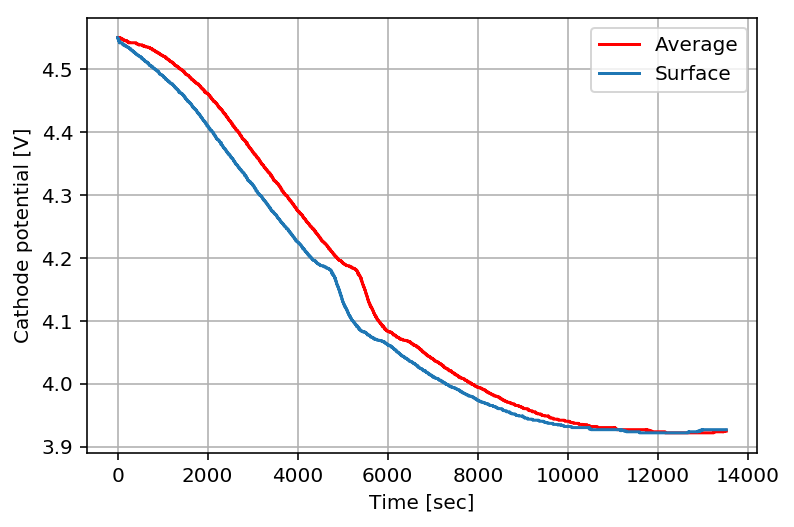

In [30]:
plt.plot(df_sim['Time (sec)'], df_sim['Cathode OCV (V)'], color = 'r', label='Average')
plt.plot(df_sim['Time (sec)'], df_sim['Cathode surface OCV (V)'], label='Surface')
plt.ylabel('Cathode potential [V]')
plt.xlabel('Time [sec]')
plt.legend()
plt.grid()
plt.show()

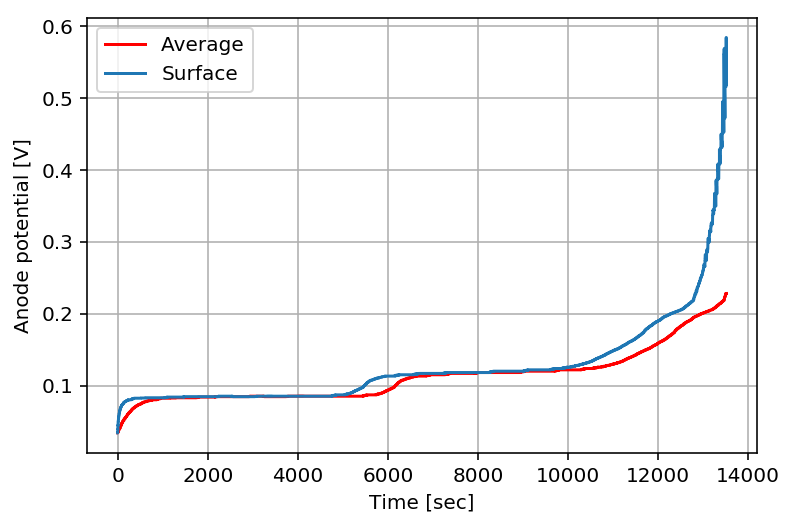

In [31]:
plt.plot(df_sim['Time (sec)'], df_sim['Anode OCV (V)'], color = 'r', label='Average')
plt.plot(df_sim['Time (sec)'], df_sim['Anode surface OCV (V)'], label='Surface')
plt.ylabel('Anode potential [V]')
plt.xlabel('Time [sec]')
plt.legend()
plt.grid()
plt.show()

## Li ion concentration in Liquid phase (Electrolyte)

In [191]:
Deff

3.75e-13

In [32]:
epsilon = 1
Deff = 7.5E-12*0.05 #[m2/sec]
t_plus = 0.363

In [138]:
t1 = time.time()
# Number of partitions of rod (finite elements)
n = 20
dx = L_el/n

t_total = 60*60*5/200 #[sec] run time
dt = 0.005 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, L_el - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_e_0*S_el
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt = np.zeros((len(t)+1))
x_rlt = np.zeros((len(t)+1,len(x)))
C_rlt = np.zeros((len(t)+1,len(C)))
x_rlt[0] = x
C_rlt[0] = C

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = 1/epsilon*(Deff*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx)# +　(1-t_plus)/F*j*S)
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = 1/epsilon*(Deff*((C[1] - C[0])/dx)/dx - 1/dx*(1-t_plus)/F*j_p*S_p)
    dCdt[n-1] = 1/epsilon*(-Deff*((C[n-1] - C[n-2])/dx)/dx + 1/dx*(1-t_plus)/F*j_n*S_n)

    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt[jj] = (jj)*dt
    x_rlt[jj] = x #
    C_rlt[jj] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
0.54 sec


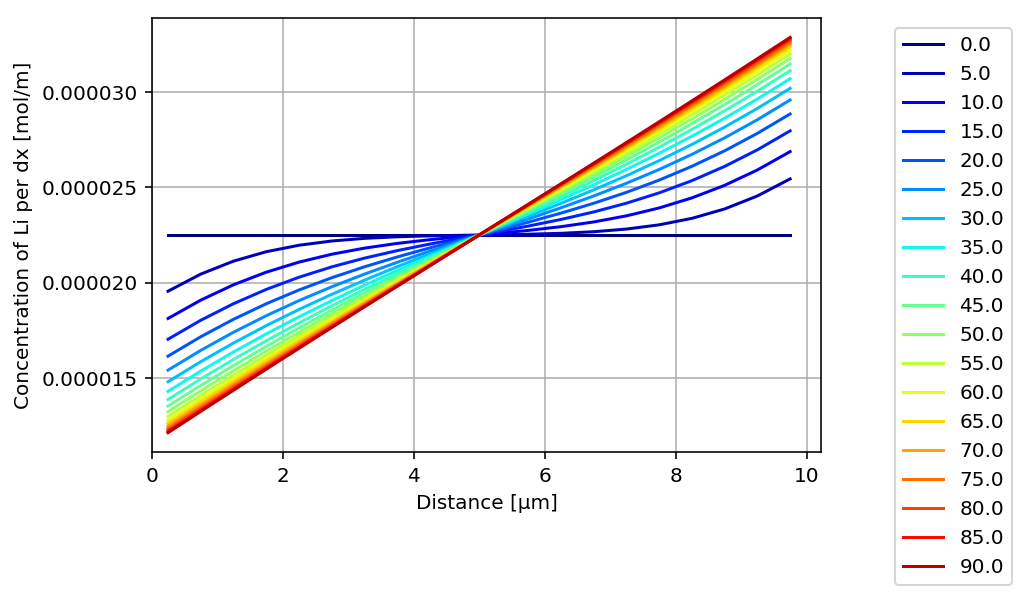

In [139]:
tt=(t_total-dt)/18#[sec] delta time for plot
for ii in range(len(time_rlt[time_rlt % tt == 0])):
    plt.plot(x_rlt[time_rlt % tt == 0][ii]*1E6,C_rlt[time_rlt % tt == 0][ii], label = time_rlt[time_rlt % tt == 0][ii],color=cm.jet(ii/len(time_rlt[time_rlt % tt == 0])))
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_xlim(left=0)
plt.grid()
plt.show()

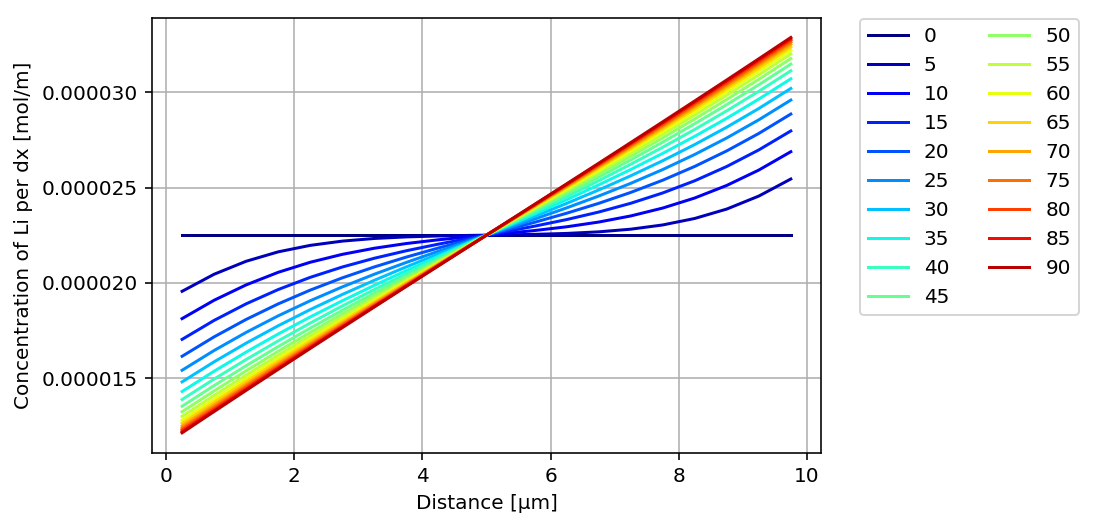

In [140]:
plot_delta_time = 5#[sec]
plot_max_time = t_total#[sec]
for ii in range(int(plot_max_time/plot_delta_time)+1):
    plt.plot(x_rlt[int(plot_delta_time/dt)*ii][:]*1E6, C_rlt[int(plot_delta_time/dt)*ii][:],color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label=plot_delta_time*ii)
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.legend(loc='upper right',
           bbox_to_anchor=(1, 0.92, 0.4, .100),ncol=2)
plt.grid()
plt.show()

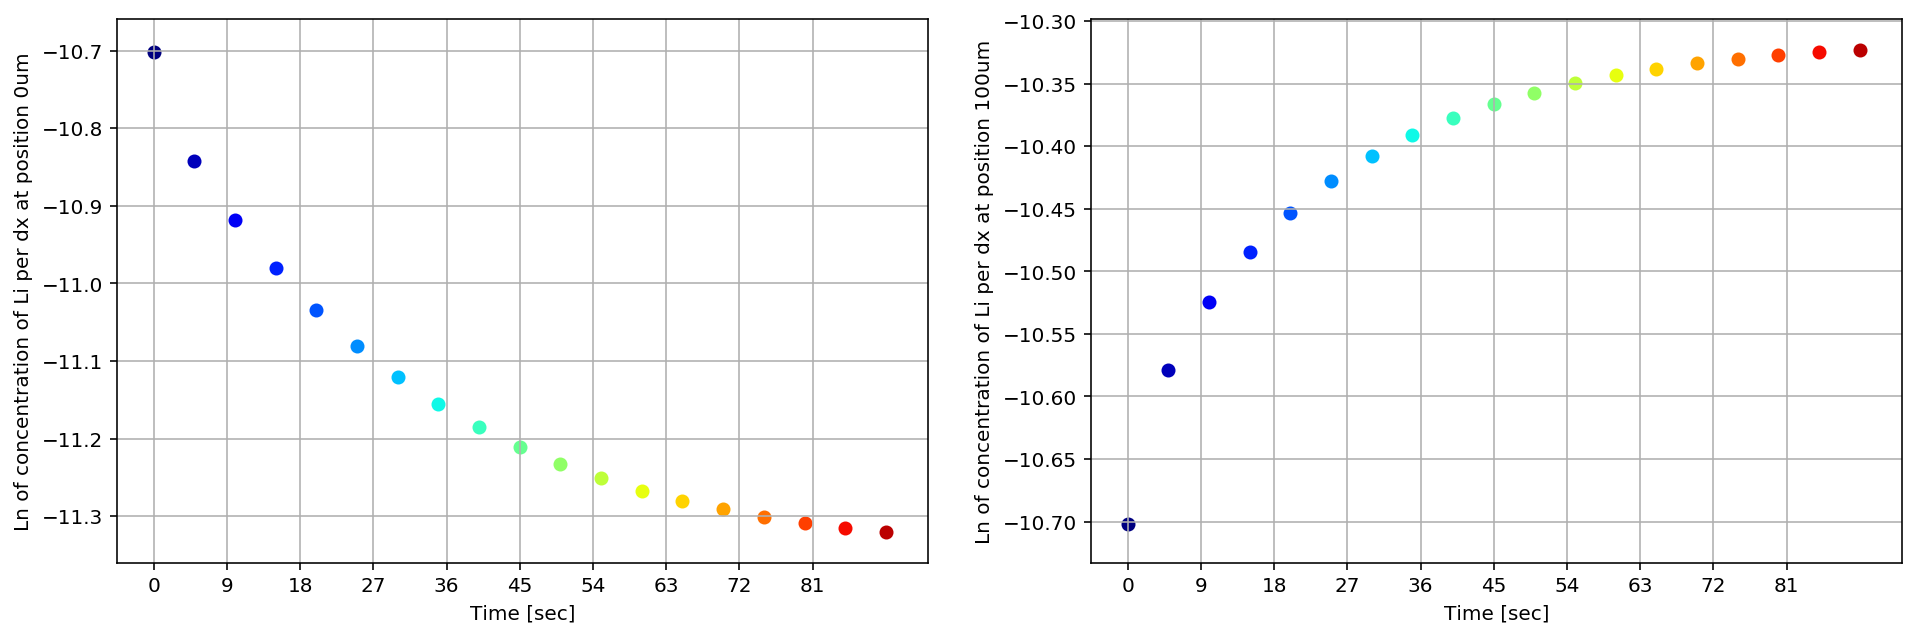

In [141]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))

for ii in range(int(plot_max_time/plot_delta_time)+1):
    ax1.scatter(time_rlt[int(plot_delta_time/dt)*ii], np.log(C_rlt[int(plot_delta_time/dt)*ii][0]),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label='Average')
    ax2.scatter(time_rlt[int(plot_delta_time/dt)*ii], np.log(C_rlt[int(plot_delta_time/dt)*ii][19]),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label='Average')
ax1.grid()
ax1.set_xlabel('Time [sec]')
ax1.set_ylabel('Ln of concentration of Li per dx at position 0um')
ax1.xaxis.set_ticks(np.arange(0, plot_max_time, plot_max_time/10))
ax2.grid()
ax2.set_xlabel('Time [sec]')
ax2.set_ylabel('Ln of concentration of Li per dx at position 100um')
ax2.xaxis.set_ticks(np.arange(0, plot_max_time, plot_max_time/10))
plt.show()

In [142]:
t1 = time.time()
# Number of partitions of rod (finite elements)
n = 20
dx = L_el/n

t_total = 60*60*5 #[sec] run time
dt = 0.05 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, L_el - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_e_0*S_el
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt = np.zeros((len(t)+1))
x_rlt = np.zeros((len(t)+1,len(x)))
C_rlt = np.zeros((len(t)+1,len(C)))
x_rlt[0] = x
C_rlt[0] = C

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = 1/epsilon*(Deff*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx)# +　(1-t_plus)/F*j*S)
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = 1/epsilon*(Deff*((C[1] - C[0])/dx)/dx - 1/dx*(1-t_plus)/F*j_p*S_p)
    dCdt[n-1] = 1/epsilon*(-Deff*((C[n-1] - C[n-2])/dx)/dx + 1/dx*(1-t_plus)/F*j_n*S_n)
    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt[jj] = (jj)*dt
    x_rlt[jj] = x #
    C_rlt[jj] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
9.1 sec


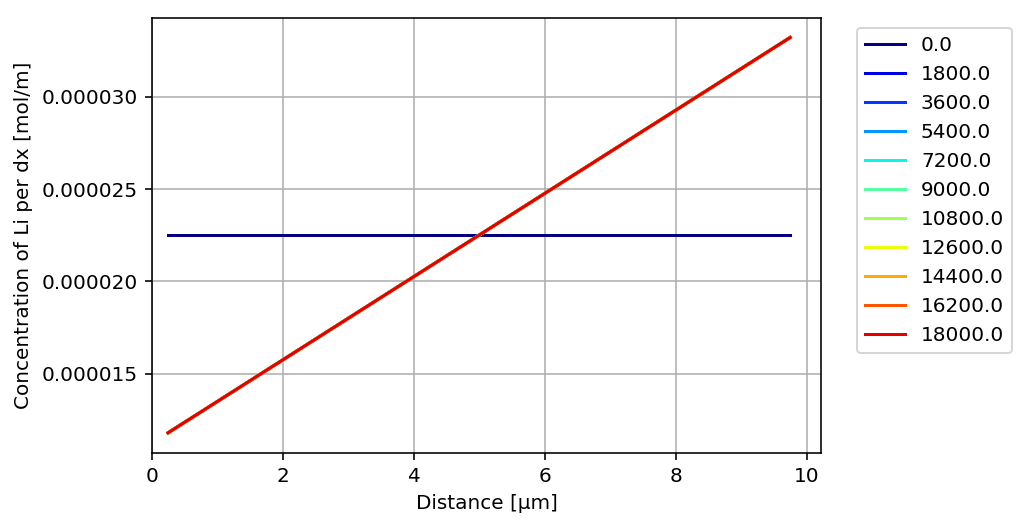

In [143]:
tt=(t_total-dt)/10#[sec] delta time for plot
for ii in range(len(time_rlt[time_rlt % tt == 0])):
    plt.plot(x_rlt[time_rlt % tt == 0][ii]*1E6,C_rlt[time_rlt % tt == 0][ii], label = time_rlt[time_rlt % tt == 0][ii],color=cm.jet(ii/len(time_rlt[time_rlt % tt == 0])))
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_xlim(left=0)
plt.grid()
plt.show()

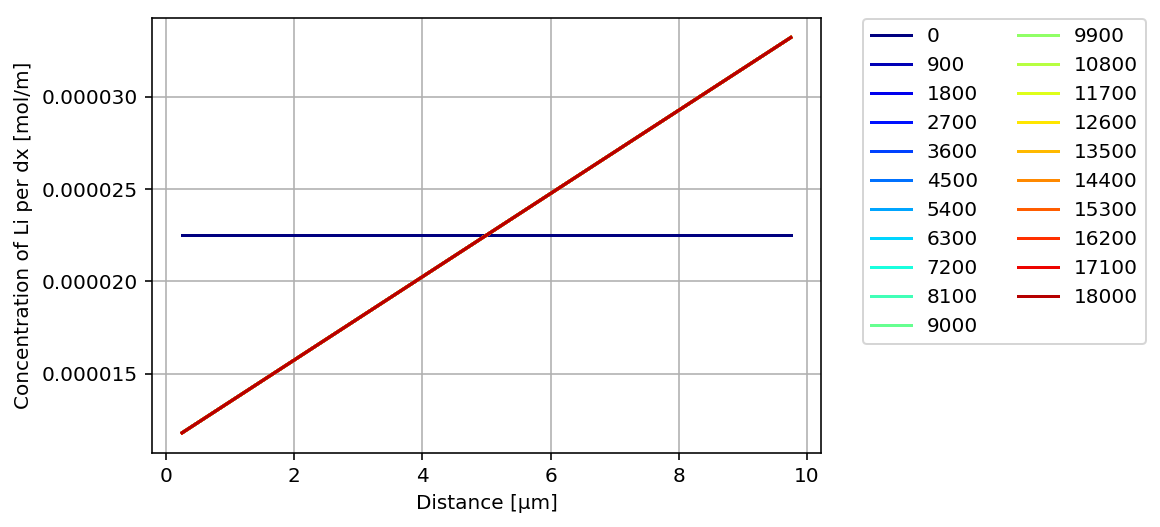

In [163]:
plot_max_time = t_total#[sec]
plot_delta_time = int(plot_max_time/20)#[sec]
for ii in range(int(plot_max_time/plot_delta_time)+1):
    plt.plot(x_rlt[int(plot_delta_time/dt)*ii][:]*1E6, C_rlt[int(plot_delta_time/dt)*ii][:],color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label=plot_delta_time*ii)
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.legend(loc='upper right',
           bbox_to_anchor=(1.1, 0.92, 0.4, .100),ncol=2)
plt.grid()
plt.show()

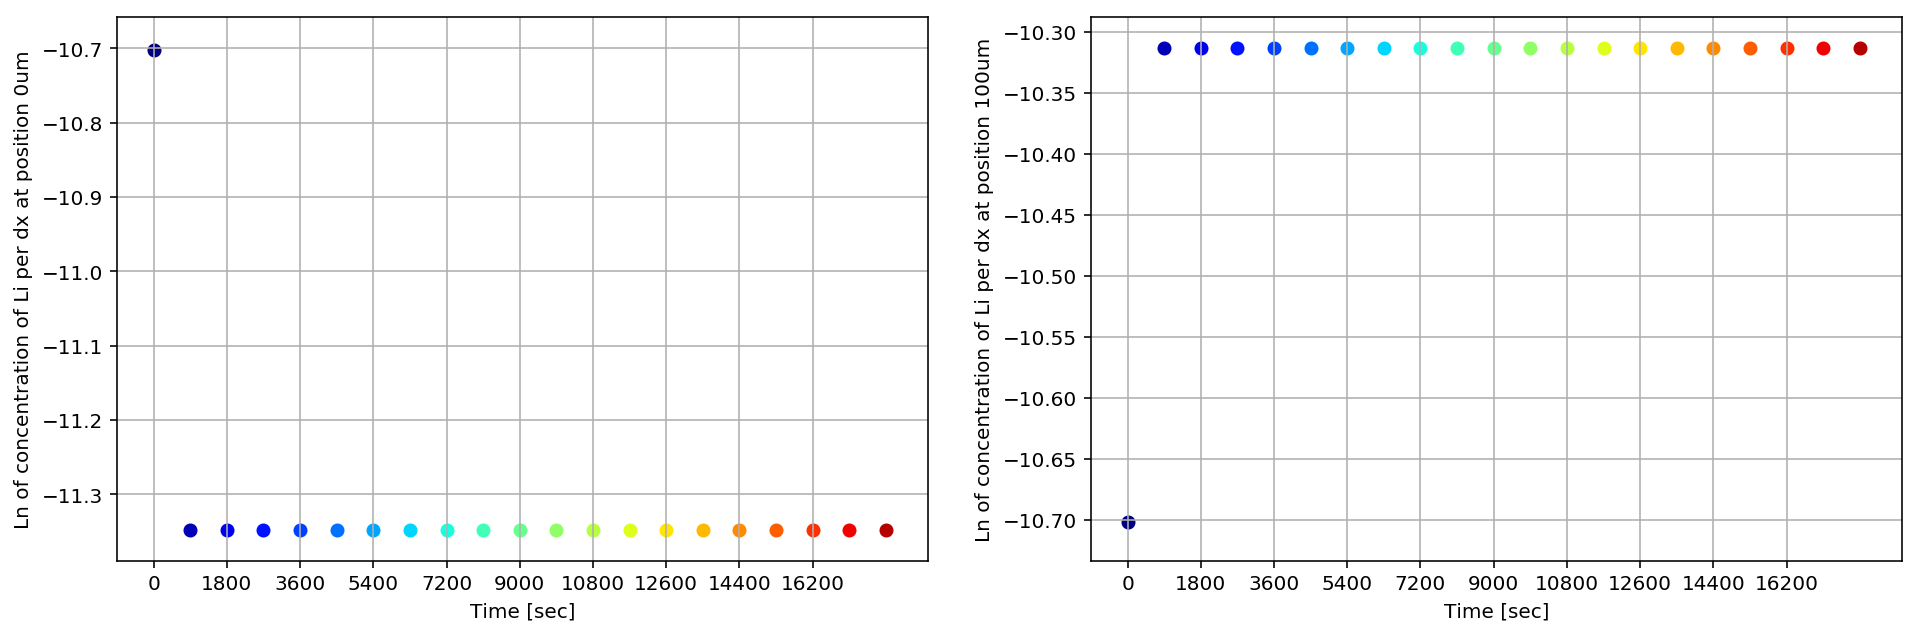

In [164]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))

for ii in range(int(plot_max_time/plot_delta_time)+1):
    ax1.scatter(time_rlt[int(plot_delta_time/dt)*ii], np.log(C_rlt[int(plot_delta_time/dt)*ii][0]),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label='Average')
    ax2.scatter(time_rlt[int(plot_delta_time/dt)*ii], np.log(C_rlt[int(plot_delta_time/dt)*ii][19]),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label='Average')
ax1.grid()
ax1.set_xlabel('Time [sec]')
ax1.set_ylabel('Ln of concentration of Li per dx at position 0um')
ax1.xaxis.set_ticks(np.arange(0, plot_max_time, plot_max_time/10))
ax2.grid()
ax2.set_xlabel('Time [sec]')
ax2.set_ylabel('Ln of concentration of Li per dx at position 100um')
ax2.xaxis.set_ticks(np.arange(0, plot_max_time, plot_max_time/10))
plt.show()

## Concentraion overpotential in electrolyte
\begin{eqnarray*}
\frac{2RT}{F}(0.5-t_+)(\ln{c_{e,k}}(x) -\ln{c_{e,k}}(x=0))
\end{eqnarray*}

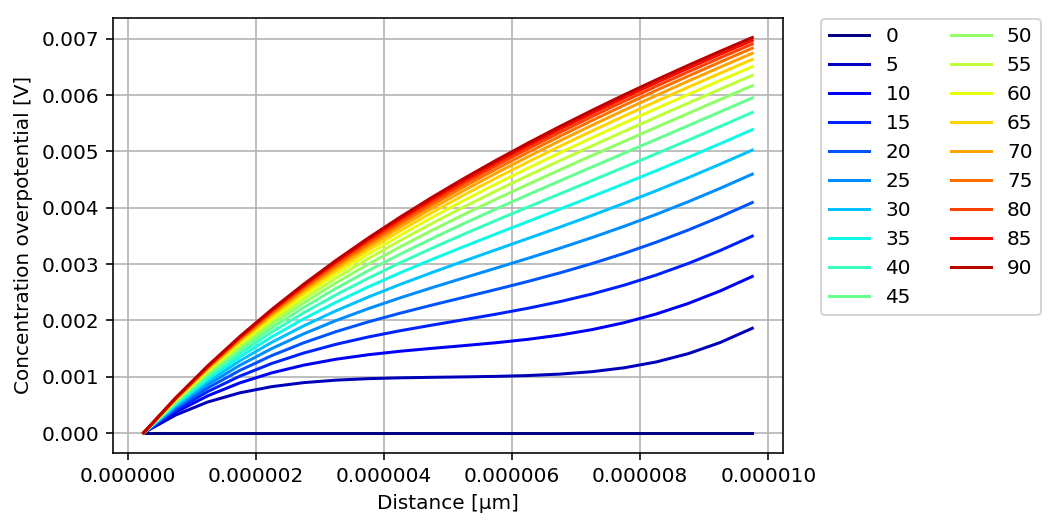

In [165]:
plot_max_time = 90 #[sec]
plot_delta_time = 5 #[sec]

for ii in range(int(plot_max_time/plot_delta_time)+1):
    plt.plot(x_rlt[int(plot_delta_time/dt)*ii][:], 2*R*T/F*(0.5-t_plus)*(np.log(C_rlt[int(plot_delta_time/dt)*ii][:])-np.log(C_rlt[int(plot_delta_time/dt)*ii][0])),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label=plot_delta_time*ii)
plt.ylabel('Concentration overpotential [V]')
plt.xlabel('Distance [μm]')
plt.legend(loc='upper right',
           bbox_to_anchor=(1, 0.92, 0.4, .100),ncol=2)
plt.grid()
plt.show()

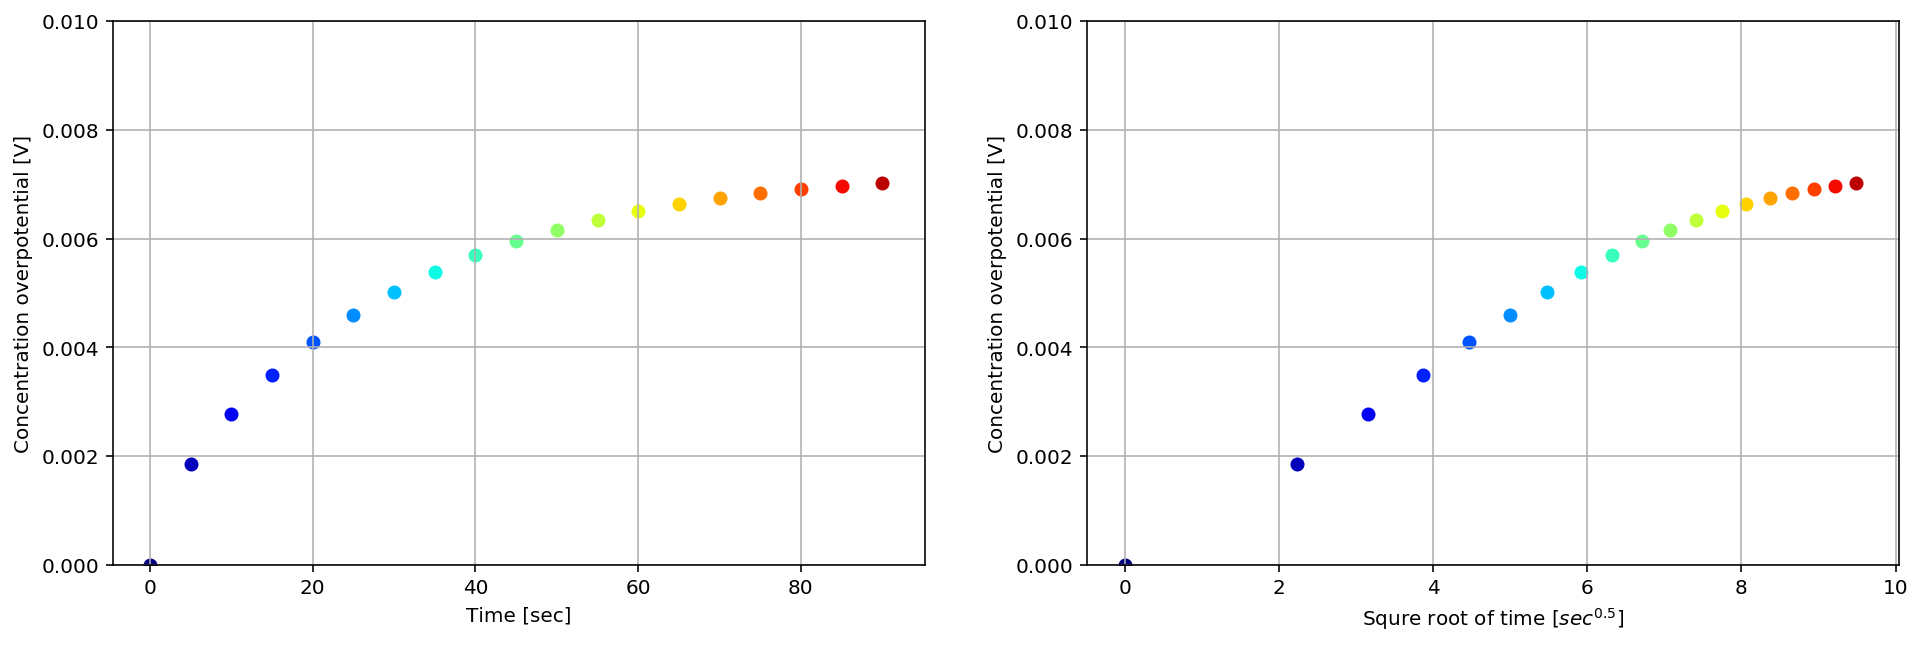

In [166]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16,5))

for ii in range(int(plot_max_time/plot_delta_time)+1):
    ax1.scatter(time_rlt[int(plot_delta_time/dt)*ii], 2*R*T/F*(0.5-t_plus)*(np.log(C_rlt[int(plot_delta_time/dt)*ii][19])-np.log(C_rlt[int(plot_delta_time/dt)*ii][0])),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label='Average')
    ax2.scatter(np.sqrt(time_rlt[int(plot_delta_time/dt)*ii]), 2*R*T/F*(0.5-t_plus)*(np.log(C_rlt[int(plot_delta_time/dt)*ii][19])-np.log(C_rlt[int(plot_delta_time/dt)*ii][0])),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label='Average')

ax1.set_ylabel('Concentration overpotential [V]')
ax2.set_ylabel('Concentration overpotential [V]')
ax1.set_ylim(0,0.01)
ax2.set_ylim(0,0.01)
ax1.set_xlabel('Time [sec]')
ax2.set_xlabel('Squre root of time [$sec^{0.5}$]')
ax1.grid()
ax2.grid()
plt.show()

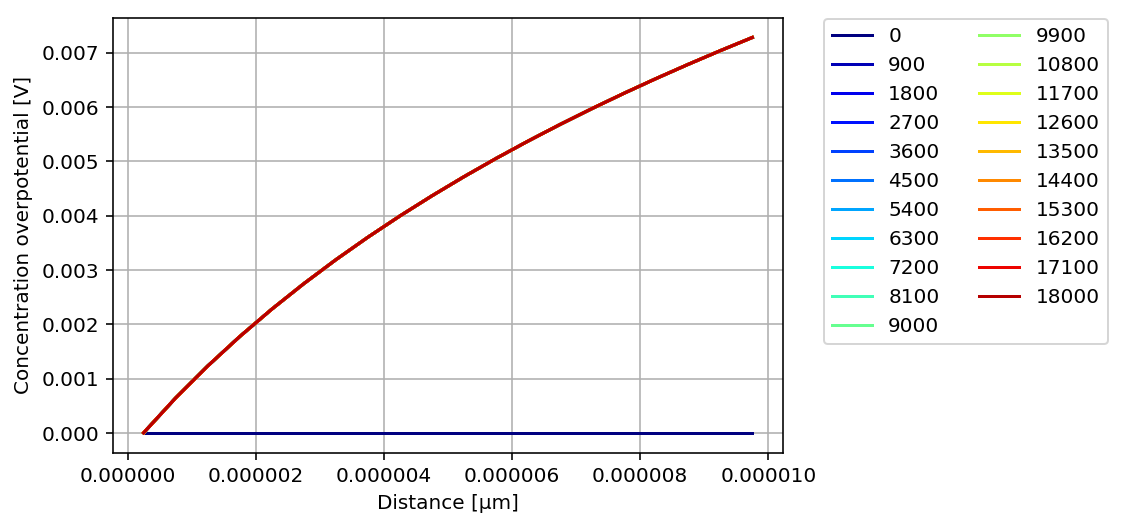

In [170]:
plot_max_time = 18000 #[sec]
plot_delta_time = 900 #[sec]

for ii in range(int(plot_max_time/plot_delta_time)+1):
    plt.plot(x_rlt[int(plot_delta_time/dt)*ii][:], 2*R*T/F*(0.5-t_plus)*(np.log(C_rlt[int(plot_delta_time/dt)*ii][:])-np.log(C_rlt[int(plot_delta_time/dt)*ii][0])),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label=plot_delta_time*ii)
plt.ylabel('Concentration overpotential [V]')
plt.xlabel('Distance [μm]')
plt.legend(loc='upper right',
           bbox_to_anchor=(1.1, 0.92, 0.4, .100),ncol=2)
plt.grid()
plt.show()

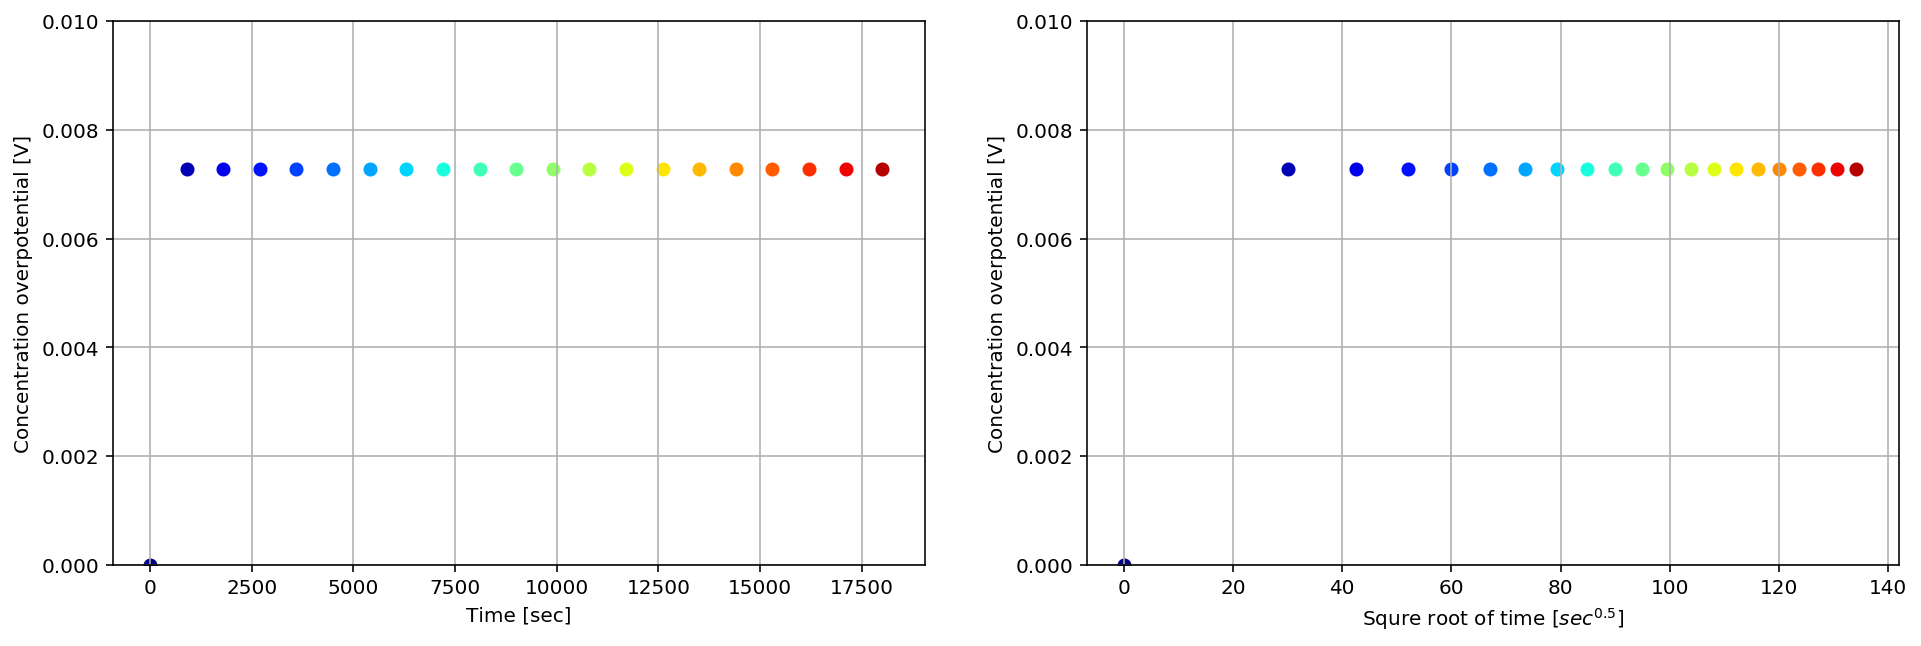

In [171]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16,5))

for ii in range(int(plot_max_time/plot_delta_time)+1):
    ax1.scatter(time_rlt[int(plot_delta_time/dt)*ii], 2*R*T/F*(0.5-t_plus)*(np.log(C_rlt[int(plot_delta_time/dt)*ii][19])-np.log(C_rlt[int(plot_delta_time/dt)*ii][0])),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label='Average')
    ax2.scatter(np.sqrt(time_rlt[int(plot_delta_time/dt)*ii]), 2*R*T/F*(0.5-t_plus)*(np.log(C_rlt[int(plot_delta_time/dt)*ii][19])-np.log(C_rlt[int(plot_delta_time/dt)*ii][0])),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label='Average')

ax1.set_ylabel('Concentration overpotential [V]')
ax2.set_ylabel('Concentration overpotential [V]')
ax1.set_ylim(0,0.01)
ax2.set_ylim(0,0.01)
ax1.set_xlabel('Time [sec]')
ax2.set_xlabel('Squre root of time [$sec^{0.5}$]')
ax1.grid()
ax2.grid()
plt.show()

## Migration overpotential in electrolyte
\begin{eqnarray*}
\Phi_{e,k}(x,t)=-\frac{x}{\kappa_{eff,k}}\frac{t_+I}{S}
\end{eqnarray*}

\begin{eqnarray*}
\kappa_{eff,k}(x,t)=\epsilon_k^{brugg_k}[4.1253 \times 10^{-2}+5.007 \times 10^{-4}c_{e,k}(x,t)
-4.7212\times10^{-7}c_{e,k}^2(x,t)+1.5094\times10^{-10}c_{e,k}^3(x,t)-1.6018\times10^{-14}c_{e,k}^4(x,t)]
\end{eqnarray*}
unit of $\kappa_{eff,k}$ is [S/m]

In [46]:
def kappa_e(C_el,epsilon_e,brugg_e):
    return epsilon_e**brugg_e*(4.1253*1E-2 + 5.007*1E-4*C_el -4.7212*1E-7*C_el**2
                               + 1.5094*1E-10*C_el**3 - 1.6018*1E-14*C_el**4)

\begin{eqnarray*}
\kappa=0.0158c_e exp(0.85c_e^{1.4}) [S/cm]
\end{eqnarray*}
[K. Smith, C.-Y. Wang / Journal of Power Sources 161 (2006) 628–639]

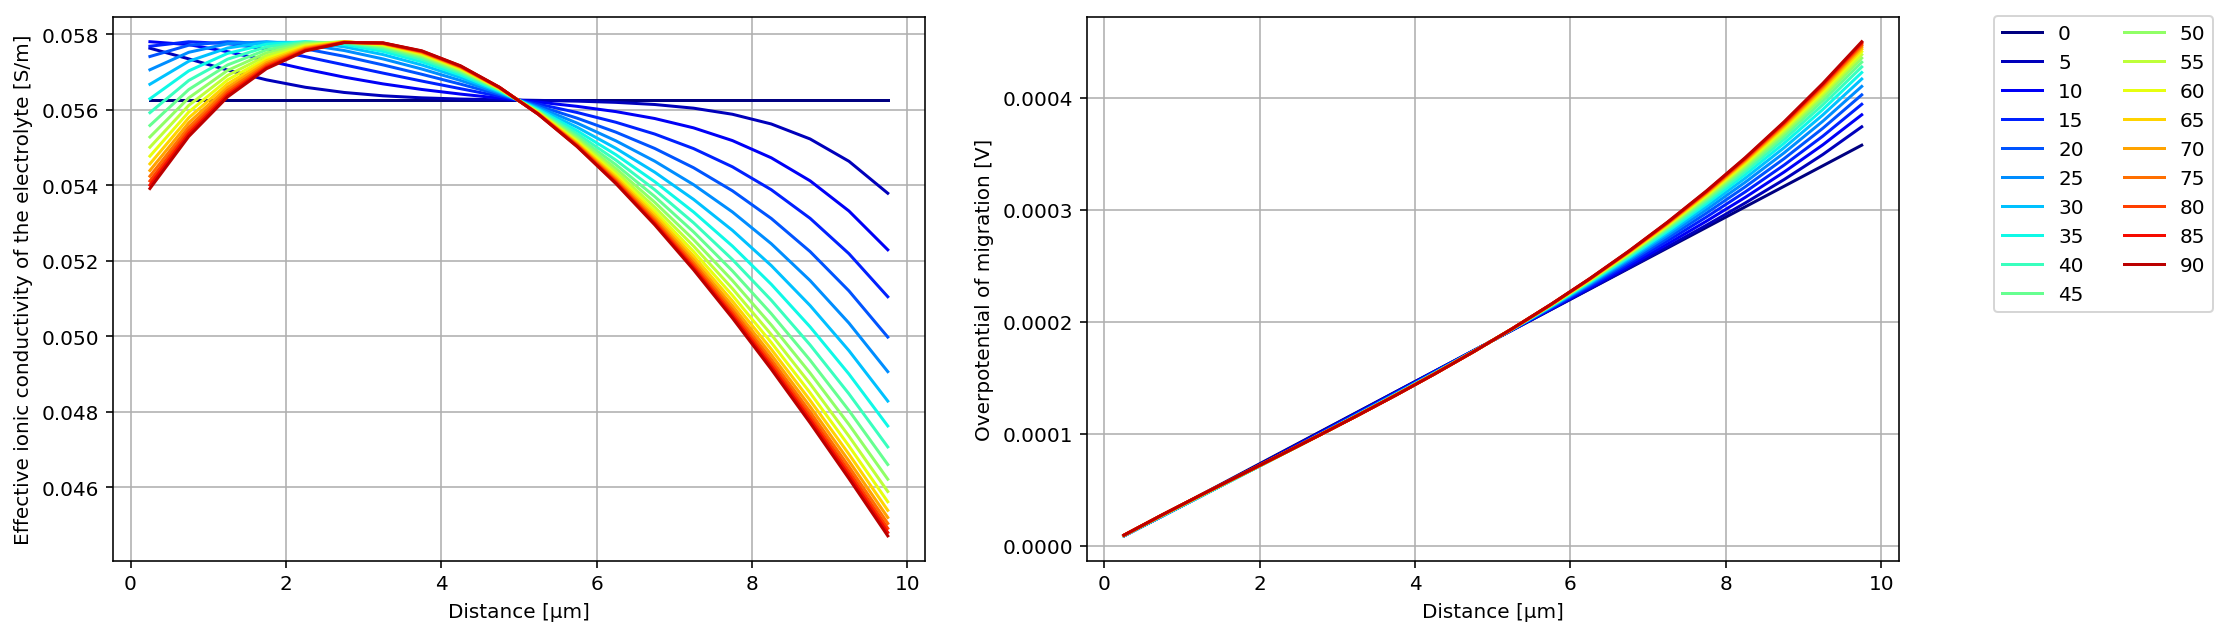

In [175]:
plot_max_time = 90 #[sec]
plot_delta_time = 5 #[sec]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16,5))

for ii in range(int(plot_max_time/plot_delta_time)+1):
    ax1.plot(x_rlt[int(plot_delta_time/dt)*ii][:]*1E6, kappa_e(C_rlt[int(plot_delta_time/dt)*ii][:]/S_el,epsilon_e,brugg_e),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)))
    ax2.plot(x_rlt[int(plot_delta_time/dt)*ii][:]*1E6, -x_rlt[int(plot_delta_time/dt)*ii][:]/kappa_e(C_rlt[int(plot_delta_time/dt)*ii][:]/S_el,epsilon_e,brugg_e)*t_plus*(-j_el),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label=plot_delta_time*ii)

ax1.set_ylabel('Effective ionic conductivity of the electrolyte [S/m]')
ax1.set_xlabel('Distance [μm]')
ax2.set_ylabel('Overpotential of migration [V]')
ax2.set_xlabel('Distance [μm]')
ax2.legend(loc='upper right',
           bbox_to_anchor=(1, 0.92, 0.4, .100),ncol=2)

ax1.grid()
ax2.grid()
plt.show()

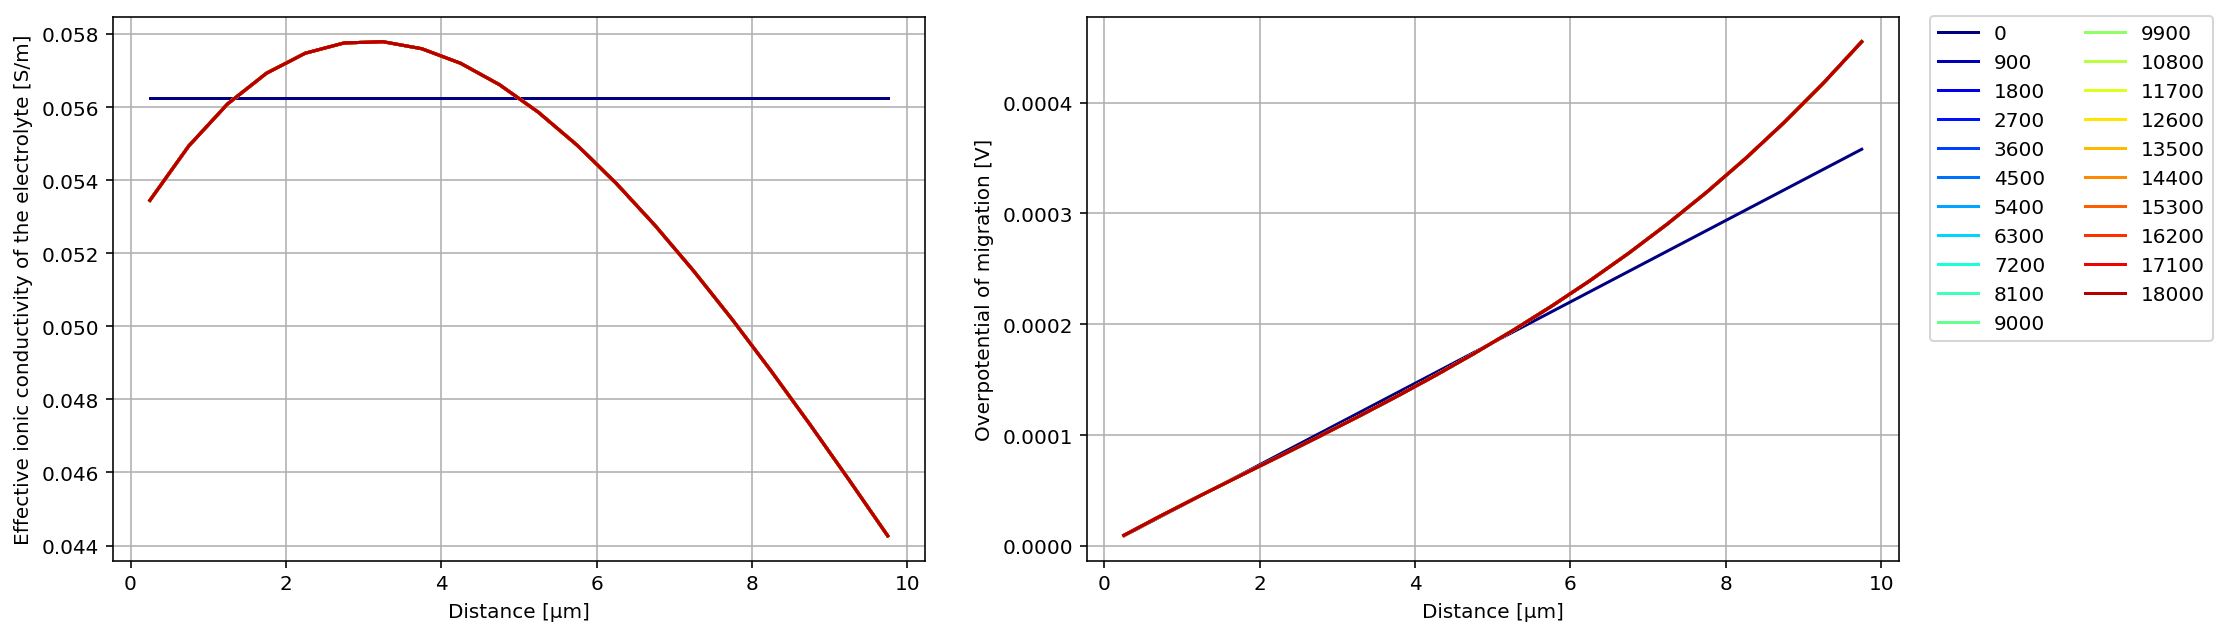

In [176]:
plot_max_time = 18000 #[sec]
plot_delta_time = 900 #[sec]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16,5))

for ii in range(int(plot_max_time/plot_delta_time)+1):
    ax1.plot(x_rlt[int(plot_delta_time/dt)*ii][:]*1E6, kappa_e(C_rlt[int(plot_delta_time/dt)*ii][:]/S_el,epsilon_e,brugg_e),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)))
    ax2.plot(x_rlt[int(plot_delta_time/dt)*ii][:]*1E6, -x_rlt[int(plot_delta_time/dt)*ii][:]/kappa_e(C_rlt[int(plot_delta_time/dt)*ii][:]/S_el,epsilon_e,brugg_e)*t_plus*(-j_el),color=cm.jet(ii/(int(plot_max_time/plot_delta_time)+1)), label=plot_delta_time*ii)

ax1.set_ylabel('Effective ionic conductivity of the electrolyte [S/m]')
ax1.set_xlabel('Distance [μm]')
ax2.set_ylabel('Overpotential of migration [V]')
ax2.set_xlabel('Distance [μm]')
ax2.legend(loc='upper right',
           bbox_to_anchor=(1, 0.92, 0.4, .100),ncol=2)

ax1.grid()
ax2.grid()
plt.show()

## Overpotential by foil electronic resistance
\begin{eqnarray*}
\rho(T) = \rho_0[1+\alpha(T-T_0)]
\end{eqnarray*}

In [177]:
#resistivity at 294.15K (20deg.C)
rho_0_Al = 2.82E-8#[ohm m]
rho_0_Cu = 1.68E-8#[ohm m]
alpha_Al = 0.0039#[/K]
alpha_Cu = 0.003862#[/K]

In [178]:
#Overpotential by foil resistance
DV_Al = rho_0_Al * (1 + alpha_Al*(T - temp_0)) * L_Al / S_Al *I
DV_Cu = rho_0_Cu * (1 + alpha_Cu*(T - temp_0)) * L_Cu / S_Cu *I
print(DV_Al)
print(DV_Cu)

1.2118810880000004e-10
5.414409907200001e-11


In [179]:
df_sim['DV_Al (V)'] = rho_0_Al * (1 + alpha_Al*(T - temp_0)) * L_Al / S_Al *I
df_sim['DV_Cu (V)'] = rho_0_Cu * (1 + alpha_Cu*(T - temp_0)) * L_Cu / S_Cu *I

In [180]:
C_rlt[:len(df_sim),19]

array([  2.25000000e-05,   2.25845061e-05,   2.26626743e-05, ...,
         3.32041071e-05,   3.32041071e-05,   3.32041071e-05])

In [181]:
df_sim["C_el_p"] = C_rlt[:len(df_sim),0]/S_el
df_sim["C_el_n"] = C_rlt[:len(df_sim),19]/S_el
df_sim

Time (sec)  C_s_p_surface (mol/m3)  C_s_n_surface (mol/m3)  \
0             0.00             4787.648000            13368.948882   
1             0.05             4788.311313            13368.252972   
2             0.10             4788.972968            13367.560867   
3             0.15             4789.632973            13366.872526   
4             0.20             4790.291336            13366.187908   
...            ...                     ...                     ...   
270343    13517.15            23476.034577              994.086164   
270344    13517.20            23476.100908              994.042669   
270345    13517.25            23476.167239              993.999175   
270346    13517.30            23476.233571              993.955681   
270347    13517.35            23476.299902              993.912186   

        Cathode x of surface (-)  Anode x of surface (-)  \
0                       0.200320                0.169631   
1                       0.200348                0.169674   
2                       0.200375                0.169717   
3                       0.200403                0.169759   
4                       0.200431                0.169802   
...                          ...                     ...   
270343                  0.982261                0.938256   
270344                  0.982264                0.938258   
270345                  0.982266                0.938261   
270346                  0.982269                0.938264   
270347                  0.982272                0.938266   

        Cathode current density (A/m2)  Anode current density (A/m2)  \
0                                 1.28                          1.28   
1                                 1.28                          1.28   
2                                 1.28                          1.28   
3                                 1.28                          1.28   
4                                 1.28                          1.28   
...                                ...                           ...   
270343                            1.28                          1.28   
270344                            1.28                          1.28   
270345                            1.28                          1.28   
270346                            1.28                          1.28   
270347                            1.28                          1.28   

        Cathode capacity (Ah)  Anode capacity (Ah)    DOD (%)      ...       \
0                0.000000e+00         0.000000e+00   0.000000      ...        
1                1.777778e-12         1.777778e-12   0.000351      ...        
2                3.555556e-12         3.555556e-12   0.000703      ...        
3                5.333333e-12         5.333333e-12   0.001054      ...        
4                7.111111e-12         7.111111e-12   0.001406      ...        
...                       ...                  ...        ...      ...        
270343           4.806098e-07         4.806098e-07  95.016989      ...        
270344           4.806116e-07         4.806116e-07  95.017340      ...        
270345           4.806133e-07         4.806133e-07  95.017692      ...        
270346           4.806151e-07         4.806151e-07  95.018043      ...        
270347           4.806169e-07         4.806169e-07  95.018395      ...        

        j_0_n (A/m2)  DV_eta_p (V)  DV_eta_n (V)  DV_el_conc_p (V)  \
0           0.927477      0.042886      0.033101          0.000000   
1           0.929312      0.042950      0.033043          0.000026   
2           0.931012      0.043010      0.032990          0.000051   
3           0.932599      0.043065      0.032940          0.000074   
4           0.934089      0.043118      0.032894          0.000095   
...              ...           ...           ...               ...   
270343      0.722570      0.106545      0.040996          0.003641   
270344      0.722555      0.106549      0.040997          0.003641   
27

## Overpotential by Butler-volmer equation

\begin{eqnarray*}
j = j_0 \left( \exp \left[\frac{\alpha_a zF\eta}{RT}\right] - \exp \left[-\frac{\alpha_c zF\eta}{RT}\right]\right)\\
j_0 = zFk^o(C_e)^{\alpha_a}(C_{s,max}-C_s)^{\alpha_a}(C_s)^{\alpha_c}
\end{eqnarray*}

\begin{eqnarray*}
\eta = \frac{RT}{\alpha zF}ln\left(\frac{j}{2j_0} + \sqrt{\left(\frac{j}{2j_0}\right)^2 + 1} \right)
\end{eqnarray*}

In [182]:
df_sim.columns

Index(['Time (sec)', 'C_s_p_surface (mol/m3)', 'C_s_n_surface (mol/m3)',
       'Cathode x of surface (-)', 'Anode x of surface (-)',
       'Cathode current density (A/m2)', 'Anode current density (A/m2)',
       'Cathode capacity (Ah)', 'Anode capacity (Ah)', 'DOD (%)',
       'Cathode x (-)', 'Cathode OCV (V)', 'Anode x (-)', 'Anode OCV (V)',
       'Cell OCV (V)', 'Cathode surface OCV (V)', 'Anode surface OCV (V)',
       'DV_Al (V)', 'DV_Cu (V)', 'C_el_p', 'C_el_n', 'j_0_p (A/m2)',
       'j_0_n (A/m2)', 'DV_eta_p (V)', 'DV_eta_n (V)', 'DV_el_conc_p (V)',
       'DV_el_conc_n (V)', 'DV_el_mig_p (V)', 'DV_el_mig_n (V)',
       'Cathode CCV (V)', 'Anode CCV (V)', 'Cell CCV (V)'],
      dtype='object')

In [183]:
df_sim['j_0_p (A/m2)'] = z*F*k_o_p*df_sim['C_el_p']**alpha*(C_s_max_p - df_sim['C_s_p_surface (mol/m3)'])**alpha*(df_sim['C_s_p_surface (mol/m3)'])**alpha#[A/m2]
df_sim['j_0_n (A/m2)'] = z*F*k_o_n*df_sim['C_el_n']**alpha*(C_s_max_n - df_sim['C_s_n_surface (mol/m3)'])**alpha*(df_sim['C_s_n_surface (mol/m3)'])**alpha#[A/m2]
df_sim['DV_eta_p (V)'] = (R*T)/(alpha*z*F)*np.log(df_sim['Cathode current density (A/m2)']/(2*df_sim['j_0_p (A/m2)']) + ((df_sim['Cathode current density (A/m2)']/(2*df_sim['j_0_p (A/m2)']))**2 + 1)**0.5)
df_sim['DV_eta_n (V)'] = (R*T)/(alpha*z*F)*np.log(df_sim['Anode current density (A/m2)']/(2*df_sim['j_0_n (A/m2)']) + ((df_sim['Anode current density (A/m2)']/(2*df_sim['j_0_n (A/m2)']))**2 + 1)**0.5)

In [184]:
df_sim['DV_el_conc_p (V)'] = (2*R*T/F*(0.5-t_plus)*(np.log(C_rlt[:len(df_sim),19])-np.log(C_rlt[:len(df_sim),0])))/2
df_sim['DV_el_conc_n (V)'] = (2*R*T/F*(0.5-t_plus)*(np.log(C_rlt[:len(df_sim),19])-np.log(C_rlt[:len(df_sim),0])))/2

In [185]:
df_sim['DV_el_mig_p (V)'] = (-L_el/kappa_e(C_rlt[:len(df_sim),19]/S_el,epsilon_e,brugg_e)*t_plus*(-j_el))/2
df_sim['DV_el_mig_n (V)'] = (-L_el/kappa_e(C_rlt[:len(df_sim),19]/S_el,epsilon_e,brugg_e)*t_plus*(-j_el))/2

In [186]:
df_sim['Cathode CCV (V)'] = df_sim['Cathode surface OCV (V)']  - df_sim['DV_Al (V)'] - df_sim['DV_eta_p (V)'] - df_sim['DV_el_conc_p (V)'] - df_sim['DV_el_mig_p (V)']
df_sim['Anode CCV (V)'] = df_sim['Anode surface OCV (V)']  + df_sim['DV_Cu (V)'] + df_sim['DV_eta_n (V)'] - df_sim['DV_el_conc_n (V)'] - df_sim['DV_el_mig_n (V)']
df_sim['Cell CCV (V)'] = df_sim['Cathode CCV (V)'] - df_sim['Anode CCV (V)']
df_sim = df_sim.dropna()
df_sim

Time (sec)  C_s_p_surface (mol/m3)  C_s_n_surface (mol/m3)  \
0             0.00             4787.648000            13368.948882   
1             0.05             4788.311313            13368.252972   
2             0.10             4788.972968            13367.560867   
3             0.15             4789.632973            13366.872526   
4             0.20             4790.291336            13366.187908   
...            ...                     ...                     ...   
270343    13517.15            23476.034577              994.086164   
270344    13517.20            23476.100908              994.042669   
270345    13517.25            23476.167239              993.999175   
270346    13517.30            23476.233571              993.955681   
270347    13517.35            23476.299902              993.912186   

        Cathode x of surface (-)  Anode x of surface (-)  \
0                       0.200320                0.169631   
1                       0.200348                0.169674   
2                       0.200375                0.169717   
3                       0.200403                0.169759   
4                       0.200431                0.169802   
...                          ...                     ...   
270343                  0.982261                0.938256   
270344                  0.982264                0.938258   
270345                  0.982266                0.938261   
270346                  0.982269                0.938264   
270347                  0.982272                0.938266   

        Cathode current density (A/m2)  Anode current density (A/m2)  \
0                                 1.28                          1.28   
1                                 1.28                          1.28   
2                                 1.28                          1.28   
3                                 1.28                          1.28   
4                                 1.28                          1.28   
...                                ...                           ...   
270343                            1.28                          1.28   
270344                            1.28                          1.28   
270345                            1.28                          1.28   
270346                            1.28                          1.28   
270347                            1.28                          1.28   

        Cathode capacity (Ah)  Anode capacity (Ah)    DOD (%)      ...       \
0                0.000000e+00         0.000000e+00   0.000000      ...        
1                1.777778e-12         1.777778e-12   0.000351      ...        
2                3.555556e-12         3.555556e-12   0.000703      ...        
3                5.333333e-12         5.333333e-12   0.001054      ...        
4                7.111111e-12         7.111111e-12   0.001406      ...        
...                       ...                  ...        ...      ...        
270343           4.806098e-07         4.806098e-07  95.016989      ...        
270344           4.806116e-07         4.806116e-07  95.017340      ...        
270345           4.806133e-07         4.806133e-07  95.017692      ...        
270346           4.806151e-07         4.806151e-07  95.018043      ...        
270347           4.806169e-07         4.806169e-07  95.018395      ...        

        j_0_n (A/m2)  DV_eta_p (V)  DV_eta_n (V)  DV_el_conc_p (V)  \
0           0.927477      0.042886      0.033101          0.000000   
1           0.929312      0.042950      0.033043          0.000026   
2           0.931012      0.043010      0.032990          0.000051   
3           0.932599      0.043065      0.032940          0.000074   
4           0.934089      0.043118      0.032894          0.000095   
...              ...           ...           ...               ...   
270343      0.722570      0.106545      0.040996          0.003641   
270344      0.722555      0.106549      0.040997          0.003641   
27

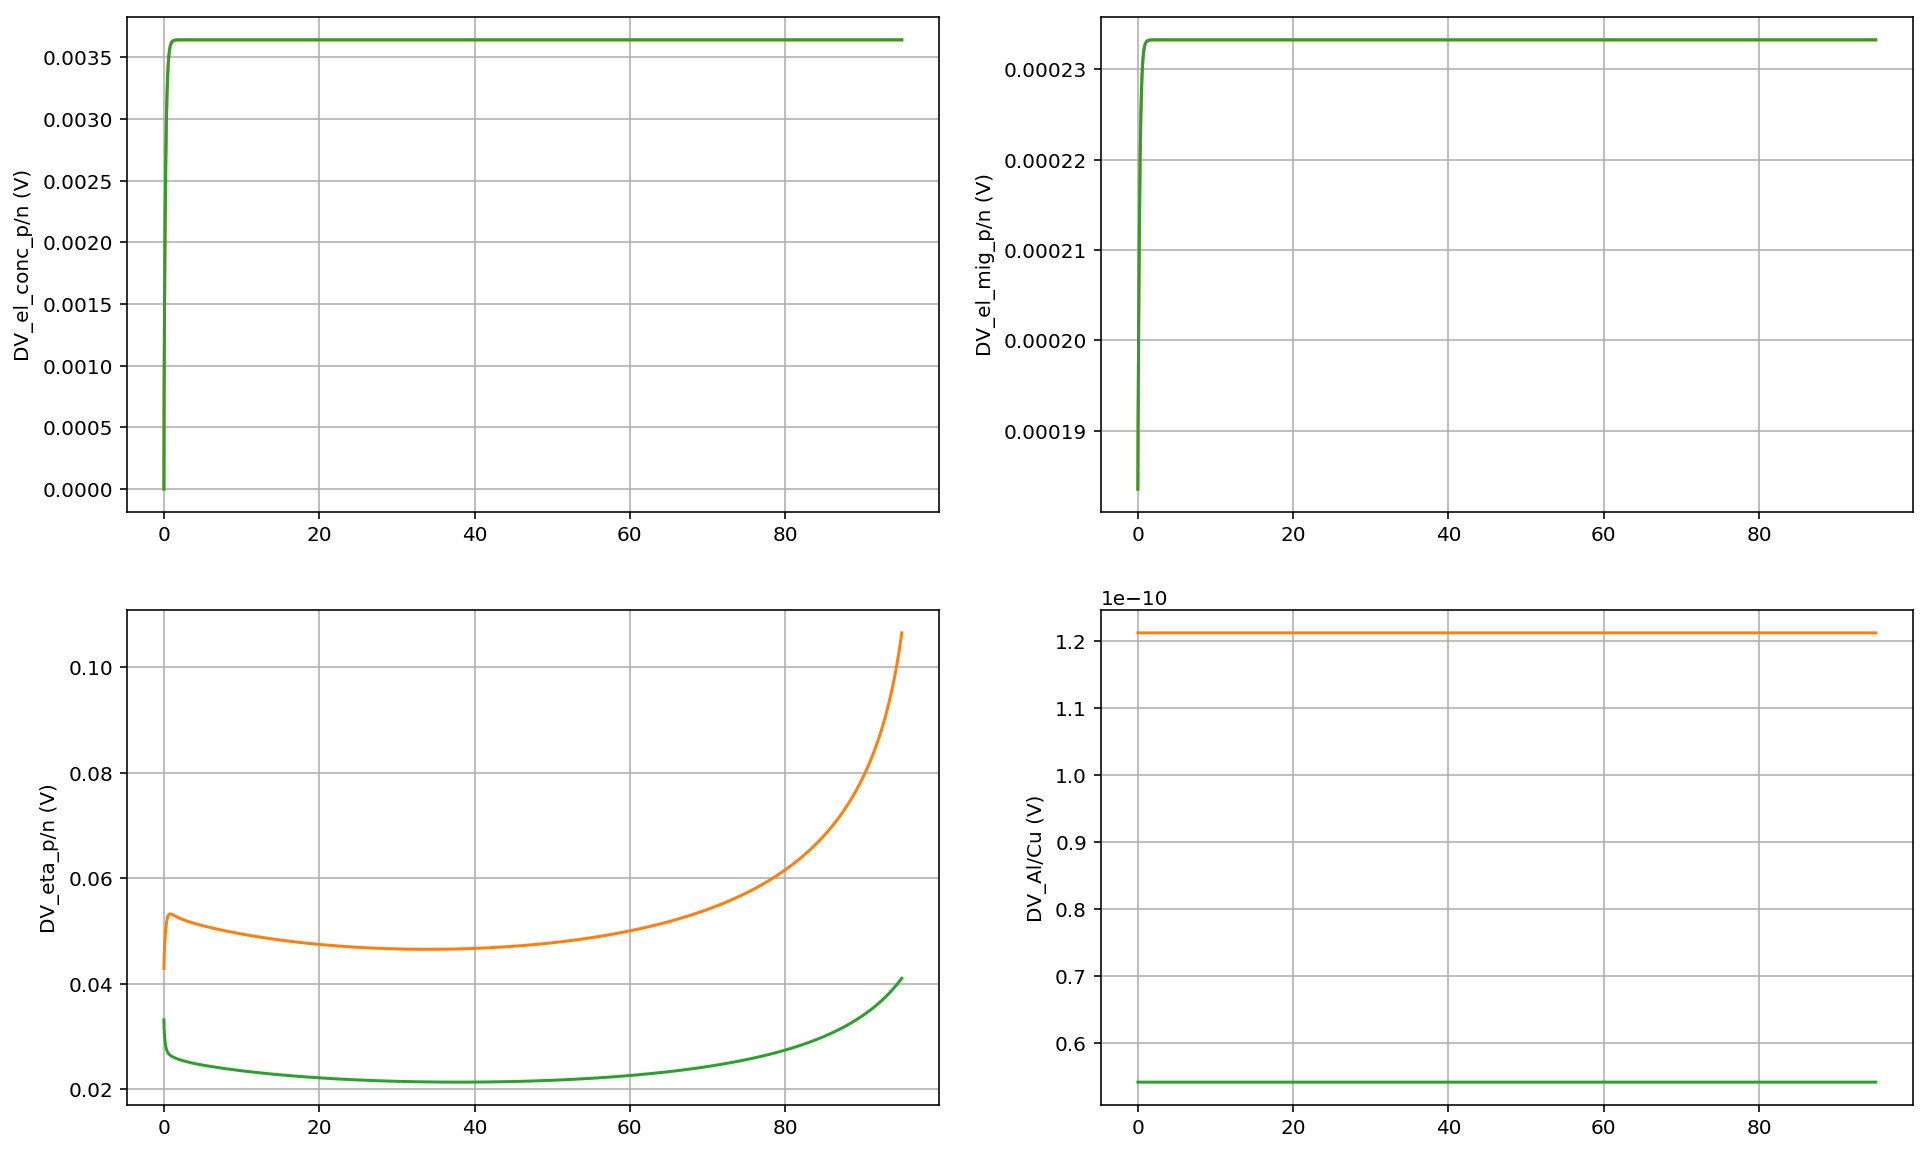

In [187]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (16,10))
ax1.plot(df_sim['DOD (%)'],df_sim['DV_el_conc_p (V)'],color = new_colors[1])
ax1.plot(df_sim['DOD (%)'],df_sim['DV_el_conc_n (V)'],color = new_colors[2])

ax2.plot(df_sim['DOD (%)'],df_sim['DV_el_mig_p (V)'],color = new_colors[1])
ax2.plot(df_sim['DOD (%)'],df_sim['DV_el_mig_n (V)'],color = new_colors[2])

ax3.plot(df_sim['DOD (%)'],df_sim['DV_eta_p (V)'],color = new_colors[1])
ax3.plot(df_sim['DOD (%)'],df_sim['DV_eta_n (V)'],color = new_colors[2])

ax4.plot(df_sim['DOD (%)'],df_sim['DV_Al (V)'],color = new_colors[1])
ax4.plot(df_sim['DOD (%)'],df_sim['DV_Cu (V)'],color = new_colors[2])

ax1.set_ylabel('DV_el_conc_p/n (V)')
ax2.set_ylabel('DV_el_mig_p/n (V)')
ax3.set_ylabel('DV_eta_p/n (V)')
ax4.set_ylabel('DV_Al/Cu (V)')

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

plt.show()

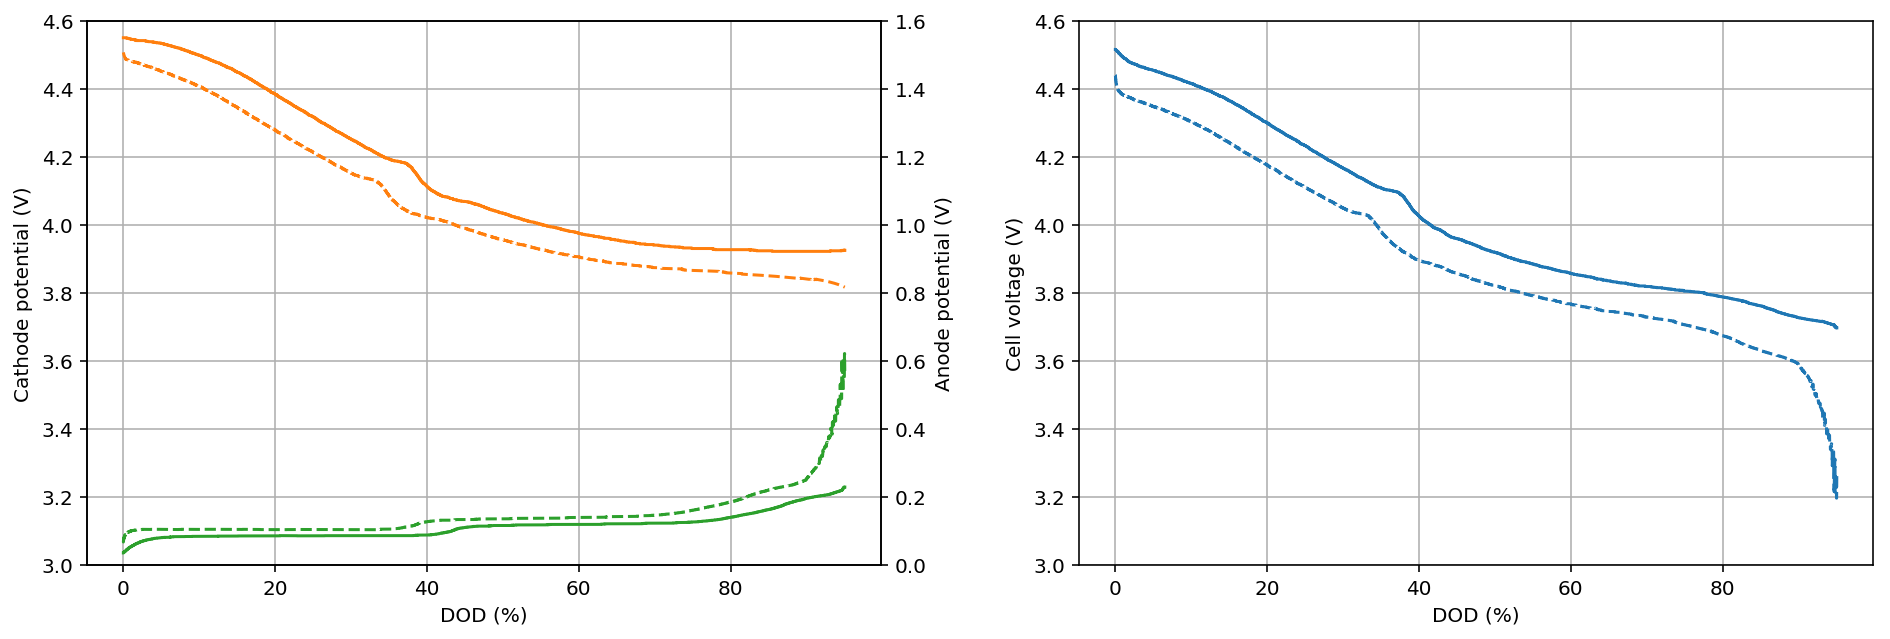

In [188]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16, 5))
plt.subplots_adjust(wspace=0.25)
ax2 = ax1.twinx()
ax1.plot(df_sim['DOD (%)'], df_sim['Cathode OCV (V)'], color = new_colors[1])
ax1.plot(df_sim['DOD (%)'], df_sim['Cathode CCV (V)'],'--', color = new_colors[1])
ax1.set_ylabel('Cathode potential (V)')
ax2.plot(df_sim['DOD (%)'], df_sim['Anode OCV (V)'], color = new_colors[2])
ax2.plot(df_sim['DOD (%)'], df_sim['Anode CCV (V)'],'--', color = new_colors[2])
ax2.set_ylabel('Anode potential (V)')
ax1.set_xlabel('DOD (%)')

ax1.set_ylim([3, 4.6])
ax2.set_ylim([0, 1.6])
ax1.grid()

ax3.plot(df_sim['DOD (%)'], df_sim['Cell OCV (V)'], color = new_colors[0])
ax3.plot(df_sim['DOD (%)'], df_sim['Cell CCV (V)'],'--', color = new_colors[0])
ax3.set_ylabel('Cell voltage (V)')
ax3.set_xlabel('DOD (%)')
ax3.set_ylim([3, 4.6])

ax3.grid()

plt.show()

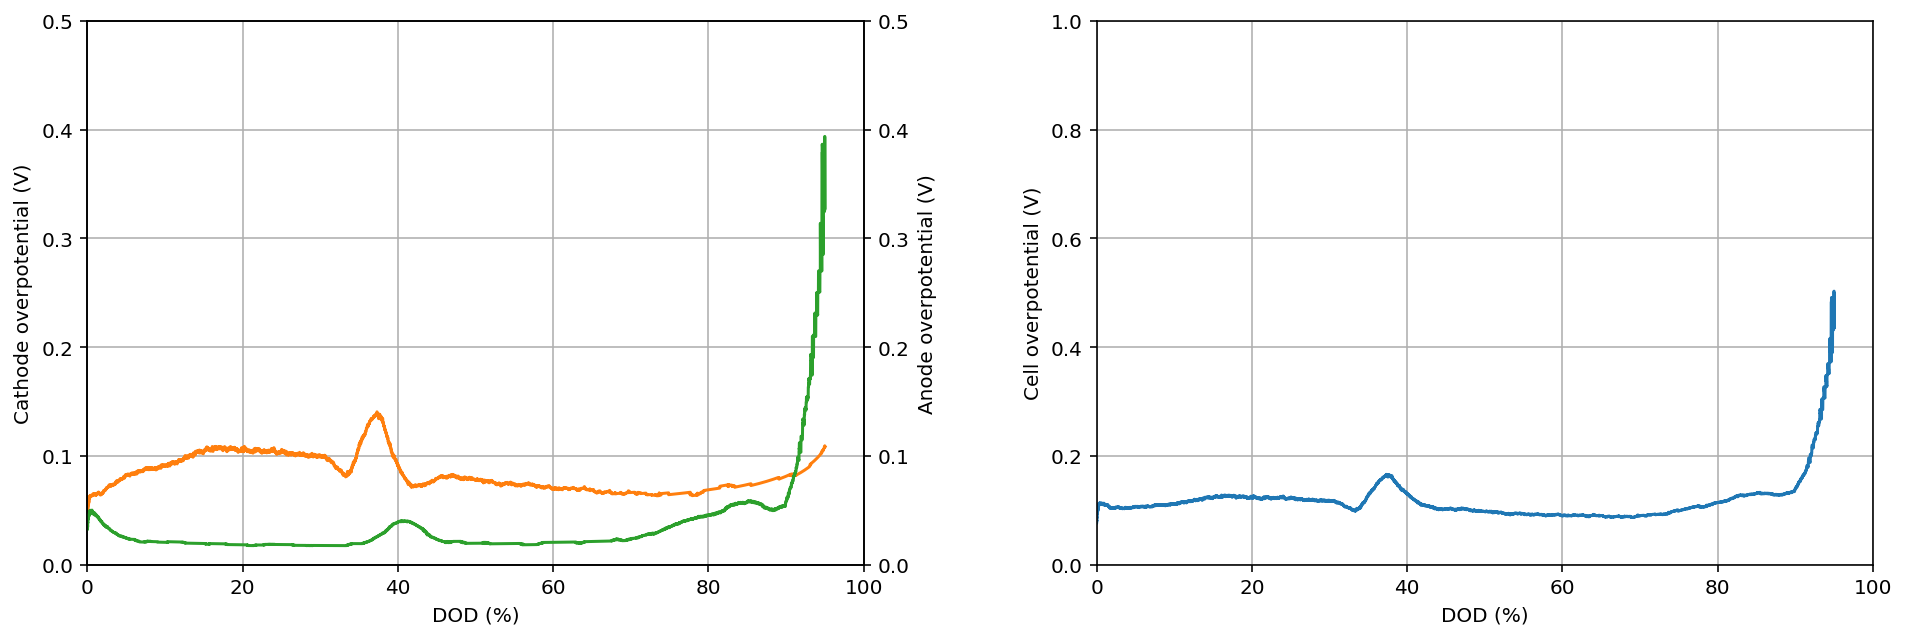

In [189]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16, 5))
plt.subplots_adjust(wspace=0.3)
ax2 = ax1.twinx()
ax1.plot(df_sim['DOD (%)'], (df_sim['Cathode OCV (V)'] - df_sim['Cathode CCV (V)']), color = new_colors[1])
ax1.set_ylabel('Cathode overpotential (V)')
ax2.plot(df_sim['DOD (%)'], (df_sim['Anode CCV (V)'] - df_sim['Anode OCV (V)']), color = new_colors[2])
ax2.set_ylabel('Anode overpotential (V)')
ax1.set_xlabel('DOD (%)')
ax1.set_ylim([0, 0.5])
ax2.set_ylim([0, 0.5])
ax1.set_xlim([0, 100])
ax1.grid()

ax3.plot(df_sim['DOD (%)'], (df_sim['Cell OCV (V)'] - df_sim['Cell CCV (V)']), color = new_colors[0])
ax3.set_ylabel('Cell overpotential (V)')
ax3.set_xlabel('DOD (%)')
ax3.set_ylim([0, 1.0])
ax3.set_xlim([0, 100])
ax3.grid()

plt.show()

## Appendix